Topic: Maryland Housing Model

Personal Project

Garrett Fanning

# Introduction

The goal of this project is to find Maryland median housing costs at what the Census Bureau defines as a "block group". This is the lowest level of granularity that the Census Bureau is able to provide. Block level is comparable in size in anywhere from a neighborhood to a small town. An example is the block group containing the largest population amount in Maryland involving a major portion of the University of Maryland, College Park campus where in this block group 13,709 people reside.
I will use the Census Bureau's database (https://data.census.gov/cedsci/) to find what I consider relevant features that could influence housing prices in an area.

Much of the code in this project will be similar my first attempt to code my own project trying to predict college basketball tournament game outcomes(https://github.com/gfanning13/Graduate_Capstone_CollegeBBall). I will attempt to customize and go into greater detail in this project to reflect a better understanding of machine learning processes and models.

# Data Description

## Source

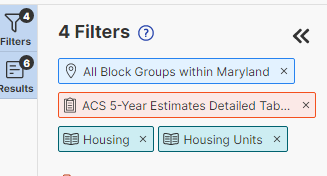

https://data.census.gov/cedsci/

## Feature Breakdown

**Housing** - Number of houses in a block
<br> **Population** - Population in a block
<br> **Earnings** - Per capita earnings in a block (past 12 months adjusted in 2020 inflation adjusted dollars)
<br> **Poverty** - Number living in poverty(based on Census income threshold) in a block
<br> **Employment** - Number of people in labor force in a block
<br> **Elders** - Number of households with someone over 60
<br> **Rooms** - Median number of rooms per house in a block
<br> **Children** - Number of children in school in a block
<br> **HouseType** - Vacant houses in a block
<br> **Age** - Median Age of a block
<br> **Transportation** - Number of people with less than a 10 minute commute
<br> **HousePrice** - Median price of a home in a block
<br> **School** - Number of schools in a block

# Libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import OLS

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.losses import mean_squared_error

import pickle
import os
import flask
from flask import Flask, redirect, url_for,request, render_template
import math

# Creating Functions

## Functions to read in and clean data

In [2]:
#Read the file in for each feature across all years available
def read_house(fileName, list_of_years):
    all_years = pd.DataFrame()
    a_dictionary = {}
    for year in list_of_years:
        filepath = fileName+'_'+year+'.csv'
        a_dictionary["%s %s" % (fileName,year)] = pd.read_csv(filepath)
        temp = pd.DataFrame.from_dict(a_dictionary["%s %s" % (fileName,year)])
        temp['Year'] = year
        all_years = pd.concat([all_years,temp])
    return all_years
    
def clean_house(original_file, feature, code):
    #Eliminate unecessary column label row
    new_file = original_file.loc[original_file[code].str.isnumeric() & original_file[code].notna()]
    #Narrow to only columns needed
    new_file = new_file[[code,"GEO_ID","NAME","Year"]]
    #Rename Columns
    new_file = new_file.rename(columns = {code:feature,"GEO_ID":"GEO_ID","NAME":"Name","Year":"Year"})
    #Convert string column to float
    new_file[feature] = new_file[feature].astype(float)
    #Do not include rows/each 'Block' with 0
    new_file = new_file.loc[(new_file[feature]>0)]
    #Sort by increasing
    new_file = new_file.sort_values(by = feature)
    return new_file
    
#Issues with Rooms data requires separate method be created
def clean_house_room(original_file, feature, code):
    #Eliminate unecessary column label row
    new_file = original_file.loc[(original_file[code].notna()) & -(original_file[code].str.contains('!') | original_file[code].str.contains('9.0+')| original_file[code].str.contains('-'))]
    #Narrow to only columns needed
    new_file = new_file[[code,"GEO_ID","NAME","Year"]]
    #Rename Columns
    new_file = new_file.rename(columns = {code:feature,"GEO_ID":"GEO_ID","NAME":"Name","Year":"Year"})
    #Convert string column to float
    new_file[feature] = new_file[feature].astype(float)
    #Do not include rows/each 'Block' with 0
    new_file = new_file.loc[(new_file[feature]>0)]
    #Sort by increasing
    new_file = new_file.sort_values(by = feature)
    return new_file


# Read Data In

## Maryland Housing Data

In [3]:
#first part of data source file name
fileName = 'Maryland_Housing'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Housing_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Units'
#code of feature before being renamed
code = 'B25001_001E'
#run clean_house method in House object
Maryland_Housing = clean_house(Maryland_Housing_Original, feature, code)
print('Records by year:\n' , Maryland_Housing['Year'].value_counts())
Maryland_Housing

Records by year:
 2020    4027
2019    3894
2017    3894
2018    3891
Name: Year, dtype: int64


Units                 GEO_ID  \
3731     3.0  1500000US245102606056   
946      3.0  1500000US240054925002   
3871     4.0  1500000US245102604041   
889      4.0  1500000US240054925002   
3716     4.0  1500000US245102604032   
...      ...                    ...   
3231  4235.0  1500000US240479503001   
3229  5603.0  1500000US240479501002   
3412  5627.0  1500000US240479501002   
3229  5688.0  1500000US240479501002   
3229  5717.0  1500000US240479501002   

                                                   Name  Year  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2017  
946   Block Group 2, Census Tract 4925, Baltimore Co...  2020  
3871  Block Group 1, Census Tract 2604.04, Baltimore...  2020  
889   Block Group 2, Census Tract 4925, Baltimore Co...  2017  
3716  Block Group 2, Census Tract 2604.03, Baltimore...  2019  
...                                                 ...   ...  
3231  Block Group 1, Census Tract 9503, Worcester Co...  2017  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2017  
3412  Block Group 2, Census Tract 9501, Worcester Co...  2020  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2018  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2019  

[15706 rows x 4 columns]

## Maryland Population Data

In [4]:
#first part of data source file name
fileName = 'Maryland_Population'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Population_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Population'
#code of feature before being renamed
code = 'B01003_001E'
#run clean_house method in House object
Maryland_Population = clean_house(Maryland_Population_Original, feature, code)
print('Records by year:\n' , Maryland_Population['Year'].value_counts())
Maryland_Population

Records by year:
 2020    4036
2017    3904
2018    3903
2019    3903
Name: Year, dtype: int64


Population                 GEO_ID  \
3731         3.0  1500000US245102606056   
365          6.0  1500000US240039800001   
365          6.0  1500000US240039800001   
392          7.0  1500000US240039800001   
3717         8.0  1500000US245102604041   
...          ...                    ...   
1174      8211.0  1500000US240178509041   
1805      8236.0  1500000US240317002051   
1174      8739.0  1500000US240178509041   
1805      8987.0  1500000US240317002051   
3082     13709.0  1500000US240339800001   

                                                   Name  Year  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2017  
365   Block Group 1, Census Tract 9800, Anne Arundel...  2018  
365   Block Group 1, Census Tract 9800, Anne Arundel...  2019  
392   Block Group 1, Census Tract 9800, Anne Arundel...  2020  
3717  Block Group 1, Census Tract 2604.04, Baltimore...  2017  
...                                                 ...   ...  
1174  Block Group 1, Census Tract 8509.04, Charles C...  2018  
1805  Block Group 1, Census Tract 7002.05, Montgomer...  2018  
1174  Block Group 1, Census Tract 8509.04, Charles C...  2019  
1805  Block Group 1, Census Tract 7002.05, Montgomer...  2019  
3082  Block Group 1, Census Tract 9800, Prince Georg...  2020  

[15746 rows x 4 columns]

## Maryland Earnings Data

In [5]:
#first part of data source file name
fileName = 'Maryland_Earnings'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Earnings_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Earnings'
#code of feature before being renamed
code = 'B19301_001E'
#run clean_house method in House object
Maryland_Earnings = clean_house(Maryland_Earnings_Original, feature, code)
print('Records by year:\n' , Maryland_Earnings['Year'].value_counts())
Maryland_Earnings

Records by year:
 2020    4027
2018    3899
2019    3898
2017    3898
Name: Year, dtype: int64


Earnings                 GEO_ID  \
890      191.0  1500000US240054926001   
3406     230.0  1500000US245101202021   
1197     624.0  1500000US240178513021   
3406     715.0  1500000US245101202021   
3128     814.0  1500000US240430110003   
...        ...                    ...   
2354  215851.0  1500000US240317055011   
2354  218577.0  1500000US240317055011   
2354  230545.0  1500000US240317055011   
2501  241917.0  1500000US240317056021   
3773  320631.0  1500000US245102201003   

                                                   Name  Year  
890   Block Group 1, Census Tract 4926, Baltimore Co...  2017  
3406  Block Group 1, Census Tract 1202.02, Baltimore...  2017  
1197  Block Group 1, Census Tract 8513.02, Charles C...  2017  
3406  Block Group 1, Census Tract 1202.02, Baltimore...  2018  
3128  Block Group 3, Census Tract 110, Washington Co...  2017  
...                                                 ...   ...  
2354  Block Group 1, Census Tract 7055.01, Montgomer...  2018  
2354  Block Group 1, Census Tract 7055.01, Montgomer...  2017  
2354  Block Group 1, Census Tract 7055.01, Montgomer...  2019  
2501  Block Group 1, Census Tract 7056.02, Montgomer...  2020  
3773  Block Group 3, Census Tract 2201, Baltimore ci...  2020  

[15722 rows x 4 columns]

## Maryland Elders

In [6]:
#first part of data source file name
fileName = 'Maryland_Elders'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Elders_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Elders'
#code of feature before being renamed
code = 'B11006_002E'
#run clean_house method in House object
Maryland_Elders = clean_house(Maryland_Elders_Original, feature, code)
print('Records by year:\n' , Maryland_Elders['Year'].value_counts())
Maryland_Elders

Records by year:
 2020    4003
2018    3873
2019    3873
2017    3867
Name: Year, dtype: int64


Elders                 GEO_ID  \
946      3.0  1500000US240054925002   
3716     4.0  1500000US245102604032   
3344     4.0  1500000US240450004001   
3393     4.0  1500000US245101002003   
889      4.0  1500000US240054925002   
...      ...                    ...   
2100  1659.0  1500000US240317014201   
633   2517.0  1500000US240054114072   
633   2523.0  1500000US240054114072   
633   2585.0  1500000US240054114072   
693   2800.0  1500000US240054114131   

                                                   Name  Year  
946   Block Group 2, Census Tract 4925, Baltimore Co...  2020  
3716  Block Group 2, Census Tract 2604.03, Baltimore...  2019  
3344  Block Group 1, Census Tract 4, Wicomico County...  2020  
3393  Block Group 3, Census Tract 1002, Baltimore ci...  2017  
889   Block Group 2, Census Tract 4925, Baltimore Co...  2018  
...                                                 ...   ...  
2100  Block Group 1, Census Tract 7014.20, Montgomer...  2018  
633   Block Group 2, Census Tract 4114.07, Baltimore...  2017  
633   Block Group 2, Census Tract 4114.07, Baltimore...  2018  
633   Block Group 2, Census Tract 4114.07, Baltimore...  2019  
693   Block Group 1, Census Tract 4114.13, Baltimore...  2020  

[15616 rows x 4 columns]

## Maryland Poverty Data

In [7]:
#first part of data source file name
fileName = 'Maryland_Poverty'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Poverty_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Poverty'
#code of feature before being renamed
code = 'B23024_002E'
#run clean_house method in House object
Maryland_Poverty = clean_house(Maryland_Poverty_Original, feature, code)
print('Records by year:\n' , Maryland_Poverty['Year'].value_counts())
Maryland_Poverty

Records by year:
 2020    3504
2018    3487
2017    3484
2019    3474
Name: Year, dtype: int64


Poverty                 GEO_ID  \
2960      1.0  1500000US240338047003   
2184      1.0  1500000US240317013132   
3689      1.0  1500000US245102602012   
2319      1.0  1500000US240317045021   
2444      1.0  1500000US240338004021   
...       ...                    ...   
3195   1098.0  1500000US240450105022   
2900   1107.0  1500000US240338070004   
3195   1176.0  1500000US240450105022   
2900   1191.0  1500000US240338070004   
3082   1633.0  1500000US240339800001   

                                                   Name  Year  
2960  Block Group 3, Census Tract 8047, Prince Georg...  2020  
2184  Block Group 2, Census Tract 7013.13, Montgomer...  2020  
3689  Block Group 2, Census Tract 2602.01, Baltimore...  2019  
2319  Block Group 1, Census Tract 7045.02, Montgomer...  2018  
2444  Block Group 1, Census Tract 8004.02, Prince Ge...  2018  
...                                                 ...   ...  
3195  Block Group 2, Census Tract 105.02, Wicomico C...  2018  
2900  Block Group 4, Census Tract 8070, Prince Georg...  2019  
3195  Block Group 2, Census Tract 105.02, Wicomico C...  2017  
2900  Block Group 4, Census Tract 8070, Prince Georg...  2018  
3082  Block Group 1, Census Tract 9800, Prince Georg...  2020  

[13949 rows x 4 columns]

## Maryland Employment Data

In [8]:
#first part of data source file name
fileName = 'Maryland_Employment'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Employment_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Employment'
#code of feature before being renamed
code = 'B23025_002E'
#run clean_house method in House object
Maryland_Employment = clean_house(Maryland_Employment_Original, feature, code)
print('Records by year:\n' , Maryland_Employment['Year'].value_counts())
Maryland_Employment

Records by year:
 2020    4027
2019    3894
2017    3893
2018    3892
Name: Year, dtype: int64


Employment                 GEO_ID  \
3716         4.0  1500000US245102604032   
3870         6.0  1500000US245102604032   
3871         7.0  1500000US245102604041   
3717         8.0  1500000US245102604041   
2480         9.0  1500000US240317050005   
...          ...                    ...   
138       5175.0  1500000US240037067001   
152       5212.0  1500000US240037301003   
138       5222.0  1500000US240037067001   
138       5325.0  1500000US240037067001   
258       5387.0  1500000US240037401022   

                                                   Name  Year  
3716  Block Group 2, Census Tract 2604.03, Baltimore...  2019  
3870  Block Group 2, Census Tract 2604.03, Baltimore...  2020  
3871  Block Group 1, Census Tract 2604.04, Baltimore...  2020  
3717  Block Group 1, Census Tract 2604.04, Baltimore...  2017  
2480  Block Group 5, Census Tract 7050, Montgomery C...  2020  
...                                                 ...   ...  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2017  
152   Block Group 3, Census Tract 7301, Anne Arundel...  2019  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2018  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2019  
258   Block Group 2, Census Tract 7401.02, Anne Arun...  2018  

[15706 rows x 4 columns]

## Maryland Rooms Data

In [9]:
#first part of data source file name
fileName = 'Maryland_Rooms'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Rooms_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Rooms'
#code of feature before being renamed
code = 'B25018_001E'
#run clean_house method in House object
Maryland_Rooms = clean_house_room(Maryland_Rooms_Original, feature, code)
print('Records by year:\n' , Maryland_Rooms['Year'].value_counts())
Maryland_Rooms

Records by year:
 2020    3580
2018    3517
2017    3514
2019    3483
Name: Year, dtype: int64


Rooms                 GEO_ID  \
3856    1.4  1500000US245102717001   
3856    1.4  1500000US245102717001   
1695    1.4  1500000US240253065002   
4009    1.4  1500000US245102717001   
3300    1.5  1500000US245100402001   
...     ...                    ...   
1188    8.5  1500000US240178510026   
2651    8.5  1500000US240338006073   
2547    8.5  1500000US240338012122   
2512    8.5  1500000US240338007012   
3185    8.5  1500000US240450103003   

                                                   Name  Year  
3856  Block Group 1, Census Tract 2717, Baltimore ci...  2019  
3856  Block Group 1, Census Tract 2717, Baltimore ci...  2018  
1695  Block Group 2, Census Tract 3065, Harford Coun...  2020  
4009  Block Group 1, Census Tract 2717, Baltimore ci...  2020  
3300  Block Group 1, Census Tract 402, Baltimore cit...  2018  
...                                                 ...   ...  
1188  Block Group 6, Census Tract 8510.02, Charles C...  2019  
2651  Block Group 3, Census Tract 8006.07, Prince Ge...  2020  
2547  Block Group 2, Census Tract 8012.12, Prince Ge...  2018  
2512  Block Group 2, Census Tract 8007.01, Prince Ge...  2018  
3185  Block Group 3, Census Tract 103, Wicomico Coun...  2019  

[14094 rows x 4 columns]

## Maryland Children Data

In [10]:
#first part of data source file name
fileName = 'Maryland_Children'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Children_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Children'
#code of feature before being renamed
code = 'B11005_002E'
#run clean_house method in House object
Maryland_Children = clean_house(Maryland_Children_Original, feature, code)
print('Records by year:\n' , Maryland_Children['Year'].value_counts())
Maryland_Children

Records by year:
 2020    3964
2017    3854
2018    3852
2019    3850
Name: Year, dtype: int64


Children                 GEO_ID  \
4009       1.0  1500000US245102717001   
2680       2.0  1500000US240338024082   
3395       2.0  1500000US245101101001   
3033       3.0  1500000US240338067113   
946        3.0  1500000US240054925002   
...        ...                    ...   
2976    1346.0  1500000US240378755003   
1174    1462.0  1500000US240178509041   
1174    1488.0  1500000US240178509041   
1805    1534.0  1500000US240317002051   
1805    1625.0  1500000US240317002051   

                                                   Name  Year  
4009  Block Group 1, Census Tract 2717, Baltimore ci...  2020  
2680  Block Group 2, Census Tract 8024.08, Prince Ge...  2019  
3395  Block Group 1, Census Tract 1101, Baltimore ci...  2019  
3033  Block Group 3, Census Tract 8067.11, Prince Ge...  2020  
946   Block Group 2, Census Tract 4925, Baltimore Co...  2020  
...                                                 ...   ...  
2976  Block Group 3, Census Tract 8755, St. Mary's C...  2019  
1174  Block Group 1, Census Tract 8509.04, Charles C...  2018  
1174  Block Group 1, Census Tract 8509.04, Charles C...  2019  
1805  Block Group 1, Census Tract 7002.05, Montgomer...  2018  
1805  Block Group 1, Census Tract 7002.05, Montgomer...  2019  

[15520 rows x 4 columns]

## Maryland HouseType Data

In [11]:
#first part of data source file name
fileName = 'Maryland_HouseType'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_HouseType_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'HouseType'
#code of feature before being renamed
code = 'B25004_001E'
#run clean_house method in House object
Maryland_HouseType = clean_house(Maryland_HouseType_Original, feature, code)
print('Records by year:\n' , Maryland_HouseType['Year'].value_counts())
Maryland_HouseType

Records by year:
 2018    2998
2017    2992
2019    2976
2020    2908
Name: Year, dtype: int64


HouseType                 GEO_ID  \
1881        1.0  1500000US240317001011   
2487        1.0  1500000US240317052002   
1838        1.0  1500000US240276068041   
1884        2.0  1500000US240317007113   
2348        2.0  1500000US240317052002   
...         ...                    ...   
3231     4068.0  1500000US240479503001   
3229     5306.0  1500000US240479501002   
3229     5339.0  1500000US240479501002   
3412     5355.0  1500000US240479501002   
3229     5355.0  1500000US240479501002   

                                                   Name  Year  
1881  Block Group 1, Census Tract 7001.01, Montgomer...  2020  
2487  Block Group 2, Census Tract 7052, Montgomery C...  2020  
1838  Block Group 1, Census Tract 6068.04, Howard Co...  2020  
1884  Block Group 3, Census Tract 7007.11, Montgomer...  2017  
2348  Block Group 2, Census Tract 7052, Montgomery C...  2019  
...                                                 ...   ...  
3231  Block Group 1, Census Tract 9503, Worcester Co...  2017  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2017  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2018  
3412  Block Group 2, Census Tract 9501, Worcester Co...  2020  
3229  Block Group 2, Census Tract 9501, Worcester Co...  2019  

[11874 rows x 4 columns]

## Maryland Age Data

In [12]:
#first part of data source file name
fileName = 'Maryland_Age'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Age_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Age'
#code of feature before being renamed
code = 'B01002_001E'
#run clean_house method in House object
Maryland_Age = clean_house_room(Maryland_Age_Original, feature, code)
print('Records by year:\n' , Maryland_Age['Year'].value_counts())
Maryland_Age

Records by year:
 2020    3985
2018    3871
2017    3868
2019    3862
Name: Year, dtype: int64


Age                 GEO_ID  \
2798   5.9  1500000US240338020021   
3717   7.5  1500000US245102604041   
3871   7.6  1500000US245102604041   
825   11.3  1500000US240054514023   
3725  11.7  1500000US245102606043   
...    ...                    ...   
2368  86.1  1500000US240317032182   
2371  86.2  1500000US240317032193   
2101  86.5  1500000US240317014202   
2101  88.5  1500000US240317014202   
2101  89.5  1500000US240317014202   

                                                   Name  Year  
2798  Block Group 1, Census Tract 8020.02, Prince Ge...  2020  
3717  Block Group 1, Census Tract 2604.04, Baltimore...  2019  
3871  Block Group 1, Census Tract 2604.04, Baltimore...  2020  
825   Block Group 3, Census Tract 4514.02, Baltimore...  2020  
3725  Block Group 3, Census Tract 2606.04, Baltimore...  2017  
...                                                 ...   ...  
2368  Block Group 2, Census Tract 7032.18, Montgomer...  2020  
2371  Block Group 3, Census Tract 7032.19, Montgomer...  2020  
2101  Block Group 2, Census Tract 7014.20, Montgomer...  2019  
2101  Block Group 2, Census Tract 7014.20, Montgomer...  2017  
2101  Block Group 2, Census Tract 7014.20, Montgomer...  2018  

[15586 rows x 4 columns]

## Maryland Transportation Data

In [13]:
#first part of data source file name
fileName = 'Maryland_Transportation'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_Transportation_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'Transportation'
#code of feature before being renamed
code = 'B08134_002E'
#run clean_house method in House object
Maryland_Transportation = clean_house(Maryland_Transportation_Original, feature, code)
print('Records by year:\n' , Maryland_Transportation['Year'].value_counts())
Maryland_Transportation

Records by year:
 2017    3402
2018    3368
2020    3352
2019    3327
Name: Year, dtype: int64


Transportation                 GEO_ID  \
3708             1.0  1500000US245102603026   
1095             1.0  1500000US240150306013   
2790             1.0  1500000US240338040012   
2430             1.0  1500000US240338002102   
3007             1.0  1500000US240378762001   
...              ...                    ...   
3195          1094.0  1500000US240450105022   
138           1226.0  1500000US240037067001   
138           1308.0  1500000US240037067001   
138           2101.0  1500000US240037067001   
137           2306.0  1500000US240037067001   

                                                   Name  Year  
3708  Block Group 6, Census Tract 2603.02, Baltimore...  2017  
1095  Block Group 3, Census Tract 306.01, Cecil Coun...  2017  
2790  Block Group 2, Census Tract 8040.01, Prince Ge...  2018  
2430  Block Group 2, Census Tract 8002.10, Prince Ge...  2019  
3007  Block Group 1, Census Tract 8762, St. Mary's C...  2017  
...                                                 ...   ...  
3195  Block Group 2, Census Tract 105.02, Wicomico C...  2017  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2018  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2017  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2019  
137   Block Group 1, Census Tract 7067, Anne Arundel...  2020  

[13449 rows x 4 columns]

## Maryland HousePrice Data

In [14]:
#first part of data source file name
fileName = 'Maryland_HousePrice'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_HousePrice_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'HousePrice'
#code of feature before being renamed
code = 'B25077_001E'
#run clean_house method in House object
Maryland_HousePrice = clean_house(Maryland_HousePrice_Original, feature, code)
print('Records by year:\n' , Maryland_HousePrice['Year'].value_counts())
Maryland_HousePrice

Records by year:
 2020    3720
2017    3665
2018    3651
2019    3650
Name: Year, dtype: int64


HousePrice                 GEO_ID  \
1595     14800.0  1500000US240253029012   
3867     18800.0  1500000US245102718023   
1517     20600.0  1500000US240253029012   
3348     20900.0  1500000US245100806002   
3537     22200.0  1500000US245101604003   
...          ...                    ...   
2333   1714300.0  1500000US240317048033   
2464   1856600.0  1500000US240317047003   
2329   1875000.0  1500000US240317047003   
2350   1904400.0  1500000US240317053001   
2329   1957000.0  1500000US240317047003   

                                                   Name  Year  
1595  Block Group 2, Census Tract 3029.01, Harford C...  2020  
3867  Block Group 3, Census Tract 2718.02, Baltimore...  2017  
1517  Block Group 2, Census Tract 3029.01, Harford C...  2018  
3348  Block Group 2, Census Tract 806, Baltimore cit...  2017  
3537  Block Group 3, Census Tract 1604, Baltimore ci...  2017  
...                                                 ...   ...  
2333  Block Group 3, Census Tract 7048.03, Montgomer...  2019  
2464  Block Group 3, Census Tract 7047, Montgomery C...  2020  
2329  Block Group 3, Census Tract 7047, Montgomery C...  2018  
2350  Block Group 1, Census Tract 7053, Montgomery C...  2017  
2329  Block Group 3, Census Tract 7047, Montgomery C...  2019  

[14686 rows x 4 columns]

## Maryland School Data

In [15]:
#first part of data source file name
fileName = 'Maryland_School'
#second part of data source file name. Loop gathers data from each year
list_of_years = ['2017','2018','2019','2020']

#run read_house method in House object
Maryland_School_Original = read_house(fileName , list_of_years)

#specific feature being used from source file
feature = 'School'
#code of feature before being renamed
code = 'B14007_002E'
#run clean_house method in House object
Maryland_School = clean_house(Maryland_School_Original, feature, code)
print('Records by year:\n' , Maryland_School['Year'].value_counts())
Maryland_School

Records by year:
 2020    4012
2019    3891
2017    3891
2018    3888
Name: Year, dtype: int64


School                 GEO_ID  \
3731      3.0  1500000US245102606056   
3230      4.0  1500000US240479501003   
3230      4.0  1500000US240479501003   
4009      5.0  1500000US245102717001   
2680      5.0  1500000US240338024082   
...       ...                    ...   
2905   5203.0  1500000US240338072003   
138    5265.0  1500000US240037067001   
138    5457.0  1500000US240037067001   
2905   5514.0  1500000US240338072003   
3082  12895.0  1500000US240339800001   

                                                   Name  Year  
3731  Block Group 6, Census Tract 2606.05, Baltimore...  2017  
3230  Block Group 3, Census Tract 9501, Worcester Co...  2019  
3230  Block Group 3, Census Tract 9501, Worcester Co...  2018  
4009  Block Group 1, Census Tract 2717, Baltimore ci...  2020  
2680  Block Group 2, Census Tract 8024.08, Prince Ge...  2017  
...                                                 ...   ...  
2905  Block Group 3, Census Tract 8072, Prince Georg...  2018  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2017  
138   Block Group 1, Census Tract 7067, Anne Arundel...  2018  
2905  Block Group 3, Census Tract 8072, Prince Georg...  2019  
3082  Block Group 1, Census Tract 9800, Prince Georg...  2020  

[15682 rows x 4 columns]

## Maryland Area Data

In [16]:
# Would've tried to use this data, but doesn't seem to be easily accessible through Census database

# Merge features into 1 DataFrame

In [17]:
# Merge datasets together using a join on GEO_ID, Year, Name
# All features have data from 2017-2020

from functools import reduce

all_columns = [Maryland_Housing,Maryland_Population,Maryland_Earnings,Maryland_Poverty,Maryland_Employment,Maryland_Rooms,Maryland_Children,\
                         Maryland_HouseType,Maryland_Age,Maryland_Transportation,Maryland_HousePrice,Maryland_School,Maryland_Elders]
    
merged_HouseData_Full = reduce(lambda  left,right: pd.merge(left,right,on=['GEO_ID','Name','Year'],how='outer'), all_columns)
merged_HouseData_Full

Units                 GEO_ID  \
0        3.0  1500000US245102606056   
1        3.0  1500000US240054925002   
2        4.0  1500000US245102604041   
3        4.0  1500000US240054925002   
4        4.0  1500000US245102604032   
...      ...                    ...   
15744    NaN  1500000US240037404001   
15745    NaN  1500000US240037404001   
15746    NaN  1500000US240037404001   
15747    NaN  1500000US240037404001   
15748    NaN  1500000US240430110001   

                                                    Name  Year  Population  \
0      Block Group 6, Census Tract 2606.05, Baltimore...  2017         3.0   
1      Block Group 2, Census Tract 4925, Baltimore Co...  2020       234.0   
2      Block Group 1, Census Tract 2604.04, Baltimore...  2020        18.0   
3      Block Group 2, Census Tract 4925, Baltimore Co...  2017       357.0   
4      Block Group 2, Census Tract 2604.03, Baltimore...  2019         8.0   
...                                                  ...   ...         ...   
15744  Block Group 1, Census Tract 7404, Anne Arundel...  2020      5636.0   
15745  Block Group 1, Census Tract 7404, Anne Arundel...  2017      5849.0   
15746  Block Group 1, Census Tract 7404, Anne Arundel...  2018      6074.0   
15747  Block Group 1, Census Tract 7404, Anne Arundel...  2019      6264.0   
15748  Block Group 1, Census Tract 110, Washington Co...  2020      6490.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
0           NaN      3.0         NaN    NaN       NaN        NaN   NaN   
1        3193.0    169.0        37.0    NaN       3.0        NaN  47.4   
2           NaN      7.0         7.0    NaN       4.0        NaN   7.6   
3        8048.0    137.0        34.0    NaN       NaN        NaN  49.5   
4           NaN      NaN         4.0    NaN       NaN        NaN   NaN   
...         ...      ...         ...    ...       ...        ...   ...   
15744    1821.0      NaN         NaN    NaN       NaN        NaN  37.9   
15745    1665.0      NaN         NaN    NaN       NaN        NaN  36.1   
15746    1770.0      NaN         NaN    NaN       NaN        NaN  36.4   
15747    1739.0      NaN         NaN    NaN       NaN        NaN  36.0   
15748    1508.0      NaN         NaN    NaN       NaN        NaN  36.2   

       Transportation  HousePrice  School  Elders  
0                 NaN         NaN     3.0     NaN  
1                 NaN         NaN     7.0     3.0  
2                 3.0         NaN    11.0     NaN  
3                 NaN         NaN     6.0     NaN  
4                 NaN         NaN     NaN     4.0  
...               ...         ...     ...     ...  
15744             NaN         NaN    44.0     NaN  
15745             NaN         NaN    58.0     NaN  
15746             NaN         NaN    43.0     NaN  
15747             NaN         NaN    42.0     NaN  
15748             NaN         NaN   610.0     NaN  

[15749 rows x 16 columns]

In [18]:
merged_HouseData_NoNAs = merged_HouseData_Full.dropna(axis=0, how='any')
merged_HouseData_NoNAs

Units                 GEO_ID  \
138     147.0  1500000US240253035021   
144     148.0  1500000US240253017024   
154     155.0  1500000US245101001003   
162     158.0  1500000US245102606042   
163     158.0  1500000US245102703011   
...       ...                    ...   
15697  4073.0  1500000US240479501001   
15702  5603.0  1500000US240479501002   
15703  5627.0  1500000US240479501002   
15704  5688.0  1500000US240479501002   
15705  5717.0  1500000US240479501002   

                                                    Name  Year  Population  \
138    Block Group 1, Census Tract 3035.02, Harford C...  2020       261.0   
144    Block Group 4, Census Tract 3017.02, Harford C...  2018       263.0   
154    Block Group 3, Census Tract 1001, Baltimore ci...  2017       218.0   
162    Block Group 2, Census Tract 2606.04, Baltimore...  2017       212.0   
163    Block Group 1, Census Tract 2703.01, Baltimore...  2020       321.0   
...                                                  ...   ...         ...   
15697  Block Group 1, Census Tract 9501, Worcester Co...  2018      1381.0   
15702  Block Group 2, Census Tract 9501, Worcester Co...  2017       647.0   
15703  Block Group 2, Census Tract 9501, Worcester Co...  2020       480.0   
15704  Block Group 2, Census Tract 9501, Worcester Co...  2018       727.0   
15705  Block Group 2, Census Tract 9501, Worcester Co...  2019       778.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
138     51785.0      7.0        94.0    8.4      19.0       25.0  62.6   
144     15362.0     84.0       100.0    4.8      51.0       31.0  44.0   
154     24605.0     21.0       103.0    6.2      32.0       69.0  32.7   
162     29198.0     15.0       107.0    4.4      13.0       32.0  47.0   
163     50826.0     34.0       183.0    7.0      24.0       30.0  57.3   
...         ...      ...         ...    ...       ...        ...   ...   
15697   44377.0     29.0       780.0    4.1      66.0     3434.0  55.4   
15702   55866.0      4.0       363.0    3.8      25.0     5306.0  49.3   
15703  130696.0     22.0       286.0    3.4      12.0     5355.0  58.0   
15704   55539.0     28.0       395.0    3.8      42.0     5339.0  47.0   
15705   50661.0     25.0       431.0    3.7      51.0     5355.0  46.6   

       Transportation  HousePrice  School  Elders  
138               9.0    407400.0    43.0    87.0  
144              41.0    117000.0    13.0    54.0  
154              11.0    118800.0    62.0    13.0  
162              26.0    118800.0    72.0    51.0  
163               8.0    214200.0    23.0    54.0  
...               ...         ...     ...     ...  
15697           261.0    323900.0   165.0   420.0  
15702            97.0    311100.0    78.0   157.0  
15703            52.0    381100.0    36.0   157.0  
15704            98.0    315200.0    93.0   171.0  
15705            91.0    342500.0   122.0   169.0  

[8075 rows x 16 columns]

In [19]:
print('Before NAs removed: ' , merged_HouseData_Full['Year'].value_counts())
print('After NAs removed: ' , merged_HouseData_NoNAs['Year'].value_counts())


Before NAs removed:  2020    4038
2017    3905
2018    3903
2019    3903
Name: Year, dtype: int64
After NAs removed:  2017    2096
2018    2076
2019    2010
2020    1893
Name: Year, dtype: int64


In [20]:
# Using this dataset going forward

HouseData_preFeatures = merged_HouseData_NoNAs

# Create test set to sample from

## Using the earnings feature to find representative groups across entire population

In [21]:
HouseData_preFeatures["income_cat"] = pd.cut(HouseData_preFeatures.loc[:,"Earnings"],
 bins=[0, 15000, 30000, 45000, 60000, np.inf],
 labels=[1, 2, 3, 4, 5])
HouseData_preFeatures["income_cat"].head(15)

<ipython-input-21-f759a67541c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HouseData_preFeatures["income_cat"] = pd.cut(HouseData_preFeatures.loc[:,"Earnings"],


138    4
144    2
154    2
162    2
163    4
167    2
169    2
170    4
177    3
179    3
192    3
195    2
201    3
203    1
208    1
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

<AxesSubplot:>

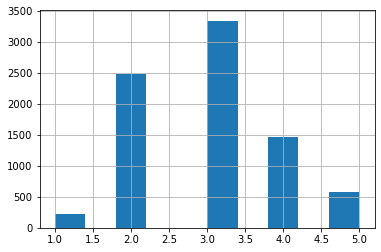

In [22]:
HouseData_preFeatures["income_cat"].hist()

In [23]:
HouseData_preFeatures["income_cat"].value_counts()

3    3338
2    2483
4    1462
5     577
1     215
Name: income_cat, dtype: int64

In [24]:
overall_bias = HouseData_preFeatures["income_cat"].value_counts() / len(HouseData_preFeatures)
overall_bias

3    0.413375
2    0.307492
4    0.181053
5    0.071455
1    0.026625
Name: income_cat, dtype: float64

## Using the earnings feature to find representative groups across random test set sample of entire population

In [25]:
random_train_set, random_test_set = train_test_split(HouseData_preFeatures, test_size=0.2, random_state=42)

In [26]:
random_test_set["income_cat"] = pd.cut(random_test_set.loc[:,"Earnings"],
 bins=[0, 15000, 30000, 45000, 60000, np.inf],
 labels=[1, 2, 3, 4, 5])
random_test_set["income_cat"].head(15)

<ipython-input-26-d0caf444492e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_test_set["income_cat"] = pd.cut(random_test_set.loc[:,"Earnings"],


2706     3
3604     3
5812     2
11136    3
12943    3
9351     2
3748     3
11232    3
4756     3
14713    3
9433     3
15331    3
13063    3
10344    2
1915     3
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

<AxesSubplot:>

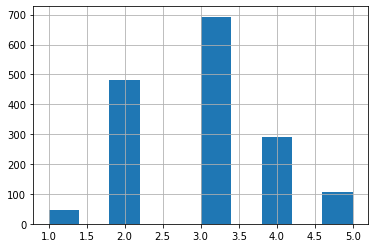

In [27]:
random_test_set["income_cat"].hist()

In [28]:
random_test_set["income_cat"].value_counts()

3    693
2    481
4    289
5    105
1     47
Name: income_cat, dtype: int64

In [29]:
random_test_bias = random_test_set["income_cat"].value_counts() / len(random_test_set)
random_test_bias

3    0.429102
2    0.297833
4    0.178947
5    0.065015
1    0.029102
Name: income_cat, dtype: float64

## Using the earnings feature to find representative groups across stratified test set sample of entire population

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(HouseData_preFeatures, HouseData_preFeatures["income_cat"]):
    strat_train_set = HouseData_preFeatures.iloc[train_index]
    strat_test_set = HouseData_preFeatures.iloc[test_index]

<AxesSubplot:>

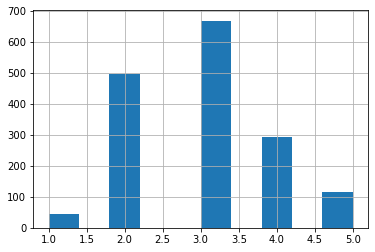

In [31]:
strat_test_set["income_cat"].hist()

In [32]:
strat_test_set["income_cat"].value_counts()

3    668
2    497
4    292
5    115
1     43
Name: income_cat, dtype: int64

In [33]:
strat_test_bias = strat_test_set["income_cat"].value_counts() / len(strat_test_set)
strat_test_bias

3    0.413622
2    0.307740
4    0.180805
5    0.071207
1    0.026625
Name: income_cat, dtype: float64

## Comparison of bias across sampling methods

In [34]:
table_bias = pd.DataFrame({'Overall':overall_bias,'Random':random_test_bias,'Stratified':strat_test_bias})
table_bias['Random_Error_Percent'] = (table_bias['Random'] - table_bias['Overall']) / table_bias['Overall'] * 100
table_bias['Stratified_Error_Percent'] = (table_bias['Stratified'] - table_bias['Overall']) / table_bias['Overall'] * 100
table_bias

Overall    Random  Stratified  Random_Error_Percent  \
3  0.413375  0.429102    0.413622              3.804673   
2  0.307492  0.297833    0.307740             -3.141361   
4  0.181053  0.178947    0.180805             -1.162791   
5  0.071455  0.065015    0.071207             -9.012132   
1  0.026625  0.029102    0.026625              9.302326   

   Stratified_Error_Percent  
3                  0.059916  
2                  0.080548  
4                 -0.136799  
5                 -0.346620  
1                  0.000000

In [35]:
# Remove income category from training and test set
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

C:\Users\gfann\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
HouseData_preFeatures = HouseData_preFeatures.drop(columns = 'income_cat')
HouseData_preFeatures.head(5)

Units                 GEO_ID  \
138  147.0  1500000US240253035021   
144  148.0  1500000US240253017024   
154  155.0  1500000US245101001003   
162  158.0  1500000US245102606042   
163  158.0  1500000US245102703011   

                                                  Name  Year  Population  \
138  Block Group 1, Census Tract 3035.02, Harford C...  2020       261.0   
144  Block Group 4, Census Tract 3017.02, Harford C...  2018       263.0   
154  Block Group 3, Census Tract 1001, Baltimore ci...  2017       218.0   
162  Block Group 2, Census Tract 2606.04, Baltimore...  2017       212.0   
163  Block Group 1, Census Tract 2703.01, Baltimore...  2020       321.0   

     Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
138   51785.0      7.0        94.0    8.4      19.0       25.0  62.6   
144   15362.0     84.0       100.0    4.8      51.0       31.0  44.0   
154   24605.0     21.0       103.0    6.2      32.0       69.0  32.7   
162   29198.0     15.0       107.0    4.4      13.0       32.0  47.0   
163   50826.0     34.0       183.0    7.0      24.0       30.0  57.3   

     Transportation  HousePrice  School  Elders  
138             9.0    407400.0    43.0    87.0  
144            41.0    117000.0    13.0    54.0  
154            11.0    118800.0    62.0    13.0  
162            26.0    118800.0    72.0    51.0  
163             8.0    214200.0    23.0    54.0

# Exploratory Data Analysis

In [37]:
HouseData_preFeatures.describe()

Units    Population       Earnings      Poverty   Employment  \
count  8075.000000   8075.000000    8075.000000  8075.000000  8075.000000   
mean    704.863034   1640.763591   37756.696594    93.855480   898.215728   
std     372.208950    847.315872   16066.608264    91.794451   495.488535   
min     147.000000    169.000000    4095.000000     1.000000    44.000000   
25%     460.000000   1036.000000   27278.000000    33.000000   545.000000   
50%     627.000000   1485.000000   35399.000000    68.000000   799.000000   
75%     870.000000   2085.500000   45092.000000   125.000000  1151.000000   
max    5717.000000  13709.000000  241917.000000  1633.000000  5387.000000   

             Rooms     Children    HouseType          Age  Transportation  \
count  8075.000000  8075.000000  8075.000000  8075.000000     8075.000000   
mean      6.075195   192.366811    83.799133    40.446316       66.705263   
std       1.196740   132.693034   190.632856     8.340922       62.082431   
min       2.500000     2.000000     2.000000    15.700000        1.000000   
25%       5.300000   101.000000    30.000000    34.400000       25.000000   
50%       6.100000   162.000000    54.000000    39.600000       49.000000   
75%       6.900000   255.000000    94.000000    45.900000       88.000000   
max       8.500000  1625.000000  5355.000000    82.600000     1094.000000   

         HousePrice        School       Elders  
count  8.075000e+03   8075.000000  8075.000000  
mean   2.751785e+05    407.809288   236.287678  
std    1.411689e+05    320.036906   137.244397  
min    1.480000e+04      7.000000     4.000000  
25%    1.810500e+05    210.000000   141.000000  
50%    2.530000e+05    338.000000   212.000000  
75%    3.412000e+05    533.000000   301.000000  
max    1.714300e+06  12895.000000  1659.000000

In [38]:
#Shouldn't be more total homes than vacant homes.
HouseData_preFeatures.loc[HouseData_preFeatures['HouseType']>HouseData_preFeatures['Units']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders]
Index: []

In [39]:
#Shouldn't be more total homes than vacant homes.
HouseData_preFeatures.loc[HouseData_preFeatures['Poverty']>HouseData_preFeatures['Population']]


Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders]
Index: []

In [40]:
#Shouldn't be more employed people than the population.
HouseData_preFeatures.loc[HouseData_preFeatures['Employment']>HouseData_preFeatures['Population']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders]
Index: []

In [41]:
#Shouldn't be more people in school than the population.
HouseData_preFeatures.loc[HouseData_preFeatures['School']>HouseData_preFeatures['Population']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders]
Index: []

In [42]:
#Shouldn't be more children than the population.
HouseData_preFeatures.loc[HouseData_preFeatures['Children']>HouseData_preFeatures['Population']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders]
Index: []

In [43]:
#Shouldn't be more people with a close commute than the population.
HouseData_preFeatures.loc[HouseData_preFeatures['Transportation']>HouseData_preFeatures['Population']]

Empty DataFrame
Columns: [Units, GEO_ID, Name, Year, Population, Earnings, Poverty, Employment, Rooms, Children, HouseType, Age, Transportation, HousePrice, School, Elders]
Index: []

## Max of each variable

In [44]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Units']==HouseData_preFeatures['Units'].max()),:]

Units                 GEO_ID  \
15705  5717.0  1500000US240479501002   

                                                    Name  Year  Population  \
15705  Block Group 2, Census Tract 9501, Worcester Co...  2019       778.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
15705   50661.0     25.0       431.0    3.7      51.0     5355.0  46.6   

       Transportation  HousePrice  School  Elders  
15705            91.0    342500.0   122.0   169.0

In [45]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Population']==HouseData_preFeatures['Population'].max()),:]

Units                 GEO_ID  \
14209  1028.0  1500000US240339800001   

                                                    Name  Year  Population  \
14209  Block Group 1, Census Tract 9800, Prince Georg...  2020     13709.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
14209    5831.0   1633.0      4133.0    5.3      17.0      195.0  19.8   

       Transportation  HousePrice   School  Elders  
14209           729.0    338800.0  12895.0   129.0

In [46]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Earnings']==HouseData_preFeatures['Earnings'].max()),:]

Units                 GEO_ID  \
12563  843.0  1500000US240317056021   

                                                    Name  Year  Population  \
12563  Block Group 1, Census Tract 7056.02, Montgomer...  2020      1103.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
12563  241917.0     24.0       330.0    4.4      15.0       47.0  76.8   

       Transportation  HousePrice  School  Elders  
12563            13.0    960200.0    36.0   730.0

In [47]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Poverty']==HouseData_preFeatures['Poverty'].max()),:]

Units                 GEO_ID  \
14209  1028.0  1500000US240339800001   

                                                    Name  Year  Population  \
14209  Block Group 1, Census Tract 9800, Prince Georg...  2020     13709.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
14209    5831.0   1633.0      4133.0    5.3      17.0      195.0  19.8   

       Transportation  HousePrice   School  Elders  
14209           729.0    338800.0  12895.0   129.0

In [48]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Rooms']==HouseData_preFeatures['Rooms'].max()),:].head(5)

Units                 GEO_ID  \
210   174.0  1500000US240253035021   
1943  314.0  1500000US240054905001   
2037  319.0  1500000US240276054012   
2501  339.0  1500000US240054905001   
2803  351.0  1500000US240317023022   

                                                   Name  Year  Population  \
210   Block Group 1, Census Tract 3035.02, Harford C...  2019       307.0   
1943  Block Group 1, Census Tract 4905, Baltimore Co...  2020       858.0   
2037  Block Group 2, Census Tract 6054.01, Howard Co...  2017       835.0   
2501  Block Group 1, Census Tract 4905, Baltimore Co...  2019       966.0   
2803  Block Group 2, Census Tract 7023.02, Montgomer...  2019       853.0   

      Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
210    53570.0      6.0       107.0    8.5      18.0       28.0  64.4   
1943  125185.0      8.0       432.0    8.5     132.0       30.0  46.3   
2037   58125.0      5.0       424.0    8.5      97.0       42.0  39.7   
2501  110917.0      8.0       489.0    8.5     137.0       22.0  48.8   
2803   75488.0     15.0       557.0    8.5      87.0       34.0  51.4   

      Transportation  HousePrice  School  Elders  
210             20.0    446500.0    46.0   121.0  
1943            32.0    685900.0   286.0   138.0  
2037            40.0    435100.0   221.0   168.0  
2501            42.0    680200.0   341.0   154.0  
2803             8.0    597300.0   167.0   146.0

In [49]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Children']==HouseData_preFeatures['Children'].max()),:]

Units                 GEO_ID  \
15667  2692.0  1500000US240317002051   

                                                    Name  Year  Population  \
15667  Block Group 1, Census Tract 7002.05, Montgomer...  2019      8987.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
15667   47975.0    255.0      4632.0    6.8    1625.0       18.0  33.7   

       Transportation  HousePrice  School  Elders  
15667            81.0    525300.0  3077.0   480.0

In [50]:
HouseData_preFeatures.loc[(HouseData_preFeatures['HouseType']==HouseData_preFeatures['HouseType'].max()),:]

Units                 GEO_ID  \
15703  5627.0  1500000US240479501002   
15705  5717.0  1500000US240479501002   

                                                    Name  Year  Population  \
15703  Block Group 2, Census Tract 9501, Worcester Co...  2020       480.0   
15705  Block Group 2, Census Tract 9501, Worcester Co...  2019       778.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
15703  130696.0     22.0       286.0    3.4      12.0     5355.0  58.0   
15705   50661.0     25.0       431.0    3.7      51.0     5355.0  46.6   

       Transportation  HousePrice  School  Elders  
15703            52.0    381100.0    36.0   157.0  
15705            91.0    342500.0   122.0   169.0

In [51]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Age']==HouseData_preFeatures['Age'].max()),:]


Units                 GEO_ID  \
15602  1960.0  1500000US240317014201   

                                                    Name  Year  Population  \
15602  Block Group 1, Census Tract 7014.20, Montgomer...  2018      2851.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
15602   57206.0     16.0       608.0    4.2      67.0      193.0  82.6   

       Transportation  HousePrice  School  Elders  
15602            22.0    298800.0   267.0  1659.0

In [52]:
HouseData_preFeatures.loc[(HouseData_preFeatures['HousePrice']==HouseData_preFeatures['HousePrice'].max()),:]

Units                 GEO_ID  \
10926  716.0  1500000US240317048033   

                                                    Name  Year  Population  \
10926  Block Group 3, Census Tract 7048.03, Montgomer...  2019      1203.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
10926   49344.0     84.0       863.0    3.4     143.0       46.0  31.0   

       Transportation  HousePrice  School  Elders  
10926            40.0   1714300.0   375.0   113.0

In [53]:
HouseData_preFeatures.loc[(HouseData_preFeatures['School']==HouseData_preFeatures['School'].max()),:]

Units                 GEO_ID  \
14209  1028.0  1500000US240339800001   

                                                    Name  Year  Population  \
14209  Block Group 1, Census Tract 9800, Prince Georg...  2020     13709.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
14209    5831.0   1633.0      4133.0    5.3      17.0      195.0  19.8   

       Transportation  HousePrice   School  Elders  
14209           729.0    338800.0  12895.0   129.0

In [54]:
HouseData_preFeatures.loc[(HouseData_preFeatures['Elders']==HouseData_preFeatures['Elders'].max()),:]

Units                 GEO_ID  \
15602  1960.0  1500000US240317014201   

                                                    Name  Year  Population  \
15602  Block Group 1, Census Tract 7014.20, Montgomer...  2018      2851.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
15602   57206.0     16.0       608.0    4.2      67.0      193.0  82.6   

       Transportation  HousePrice  School  Elders  
15602            22.0    298800.0   267.0  1659.0

## Remove outlier

In [55]:
#University of Maryland campus
HouseData_preFeatures.loc[(HouseData_preFeatures['GEO_ID']=='1500000US240339800001'),:]

Units                 GEO_ID  \
14209  1028.0  1500000US240339800001   

                                                    Name  Year  Population  \
14209  Block Group 1, Census Tract 9800, Prince Georg...  2020     13709.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
14209    5831.0   1633.0      4133.0    5.3      17.0      195.0  19.8   

       Transportation  HousePrice   School  Elders  
14209           729.0    338800.0  12895.0   129.0

In [56]:
#Salisbury University
HouseData_preFeatures.loc[(HouseData_preFeatures['GEO_ID']=='1500000US240450105022'),:]

Units                 GEO_ID  \
15506  1601.0  1500000US240450105022   
15546  1679.0  1500000US240450105022   

                                                    Name  Year  Population  \
15506  Block Group 2, Census Tract 105.02, Wicomico C...  2018      4966.0   
15546  Block Group 2, Census Tract 105.02, Wicomico C...  2017      5024.0   

       Earnings  Poverty  Employment  Rooms  Children  HouseType   Age  \
15506   12055.0   1098.0      2374.0    5.0     335.0      370.0  20.9   
15546   11668.0   1176.0      2520.0    5.0     235.0      418.0  21.1   

       Transportation  HousePrice  School  Elders  
15506          1070.0    189200.0  3494.0   172.0  
15546          1094.0    162500.0  3408.0   189.0

In [57]:
#Remove row containing outlier data involving University of Maryland Salisbury campuses. Also a major senior housing project area is removed.
#Used max of school,poverty, age, and elder variables to see how these rows stand out.

print(HouseData_preFeatures['Name'].notnull().sum())
HouseData_preFeatures= HouseData_preFeatures.loc[-(HouseData_preFeatures['GEO_ID'].isin(['1500000US240339800001','1500000US240450105022','1500000US240317014201'])),:]
print(HouseData_preFeatures['Name'].notnull().sum())

8075
8071


## Visualizations

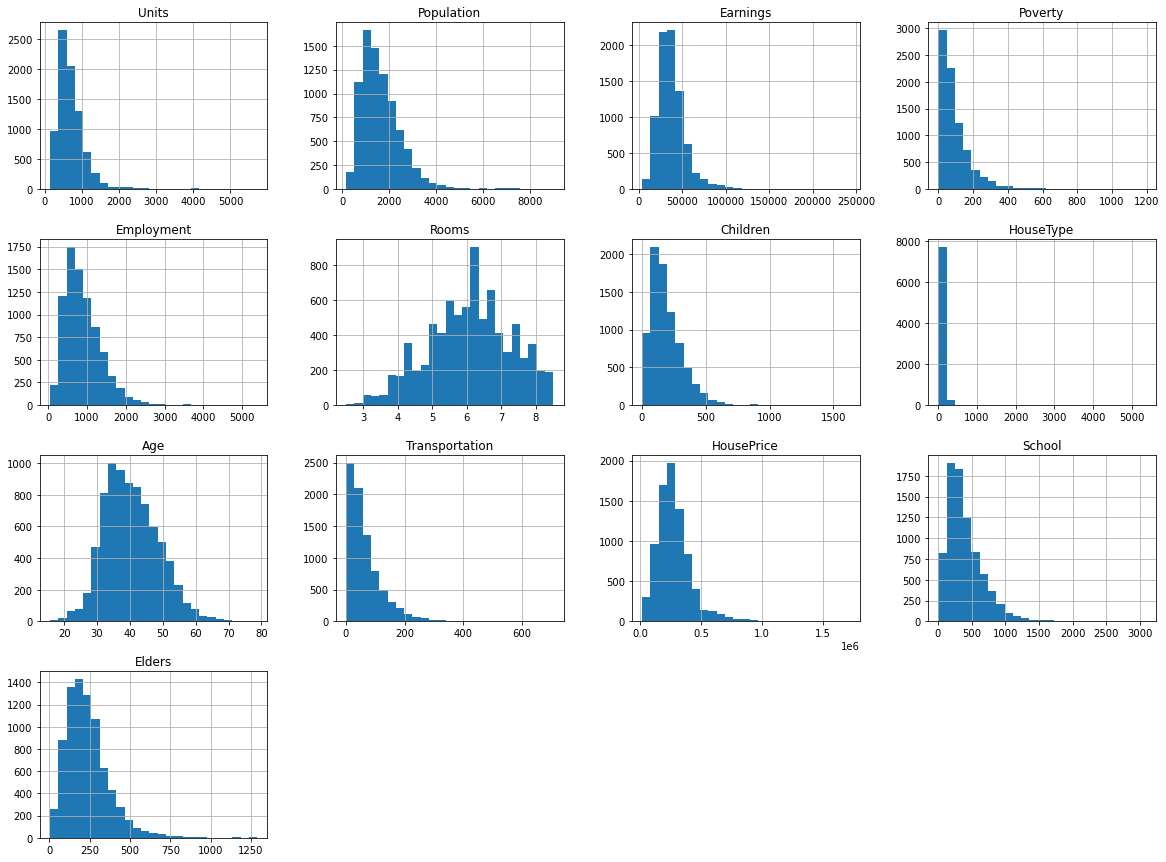

In [58]:
#Plot histograms of each variable
HouseData_preFeatures.hist(bins=25, figsize=(20,15))
plt.show()

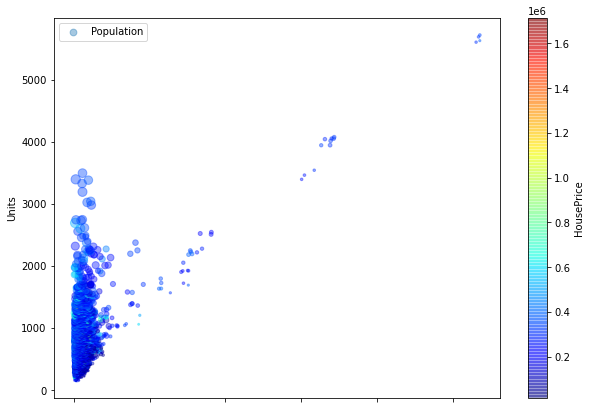

In [59]:
HouseData_preFeatures.plot(kind="scatter", x="HouseType", y="Units", alpha=0.4,
 s=HouseData_preFeatures["Population"]/100, label="Population", figsize=(10,7),
 c="HousePrice", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

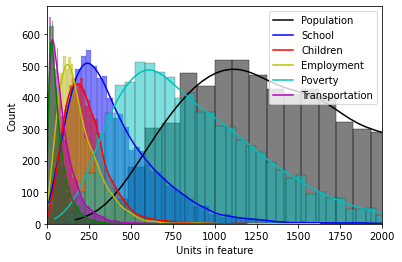

In [60]:
# plotting both distibutions on the same figure
fig = sns.histplot(HouseData_preFeatures['Population'], kde =True, color = 'black')
fig = sns.histplot(HouseData_preFeatures['School'],kde =True, color = 'b')
fig = sns.histplot(HouseData_preFeatures['Elders'], kde =True, color = 'r')
fig = sns.histplot(HouseData_preFeatures['Children'], kde =True, color = 'y')
fig = sns.histplot(HouseData_preFeatures['Employment'],kde =True, color = 'c')
fig = sns.histplot(HouseData_preFeatures['Poverty'], kde =True, color = 'm')
fig = sns.histplot(HouseData_preFeatures['Transportation'], kde =True, color = 'g')

plt.xlim(0, 2000)
plt.xlabel('Units in feature')
plt.legend(labels = ['Population','School','Children','Employment','Poverty','Transportation'])
plt.show()




## Correlation

In [61]:
corr_matrix = HouseData_preFeatures.corr()
corr_matrix

Units  Population  Earnings   Poverty  Employment  \
Units           1.000000    0.763694  0.171410  0.243772    0.752416   
Population      0.763694    1.000000  0.066797  0.276074    0.950850   
Earnings        0.171410    0.066797  1.000000 -0.371484    0.161824   
Poverty         0.243772    0.276074 -0.371484  1.000000    0.212933   
Employment      0.752416    0.950850  0.161824  0.212933    1.000000   
Rooms          -0.172046    0.059469  0.247699 -0.371822    0.036445   
Children        0.627933    0.892955 -0.012774  0.236969    0.836638   
HouseType       0.535537   -0.015530  0.023727  0.036386   -0.027521   
Age            -0.027668   -0.230354  0.344724 -0.358559   -0.246594   
Transportation  0.391694    0.385774 -0.001866  0.211866    0.374444   
HousePrice      0.144814    0.185368  0.728548 -0.251223    0.223606   
School          0.568742    0.866635 -0.058454  0.325362    0.793701   
Elders          0.614561    0.599714  0.236077  0.023496    0.501548   

                   Rooms  Children  HouseType       Age  Transportation  \
Units          -0.172046  0.627933   0.535537 -0.027668        0.391694   
Population      0.059469  0.892955  -0.015530 -0.230354        0.385774   
Earnings        0.247699 -0.012774   0.023727  0.344724       -0.001866   
Poverty        -0.371822  0.236969   0.036386 -0.358559        0.211866   
Employment      0.036445  0.836638  -0.027521 -0.246594        0.374444   
Rooms           1.000000  0.085753  -0.147035  0.268650       -0.077146   
Children        0.085753  1.000000  -0.050282 -0.335872        0.307701   
HouseType      -0.147035 -0.050282   1.000000  0.113237        0.095676   
Age             0.268650 -0.335872   0.113237  1.000000       -0.108675   
Transportation -0.077146  0.307701   0.095676 -0.108675        1.000000   
HousePrice      0.288786  0.143622  -0.024967  0.200824        0.022683   
School          0.061693  0.829559  -0.042473 -0.417258        0.353494   
Elders          0.117277  0.379452   0.068148  0.379397        0.270744   

                HousePrice    School    Elders  
Units             0.144814  0.568742  0.614561  
Population        0.185368  0.866635  0.599714  
Earnings          0.728548 -0.058454  0.236077  
Poverty          -0.251223  0.325362  0.023496  
Employment        0.223606  0.793701  0.501548  
Rooms             0.288786  0.061693  0.117277  
Children          0.143622  0.829559  0.379452  
HouseType        -0.024967 -0.042473  0.068148  
Age               0.200824 -0.417258  0.379397  
Transportation    0.022683  0.353494  0.270744  
HousePrice        1.000000  0.138999  0.208996  
School            0.138999  1.000000  0.344635  
Elders            0.208996  0.344635  1.000000

In [62]:
corr_matrix['HousePrice'].sort_values(ascending = False)

HousePrice        1.000000
Earnings          0.728548
Rooms             0.288786
Employment        0.223606
Elders            0.208996
Age               0.200824
Population        0.185368
Units             0.144814
Children          0.143622
School            0.138999
Transportation    0.022683
HouseType        -0.024967
Poverty          -0.251223
Name: HousePrice, dtype: float64

<AxesSubplot:>

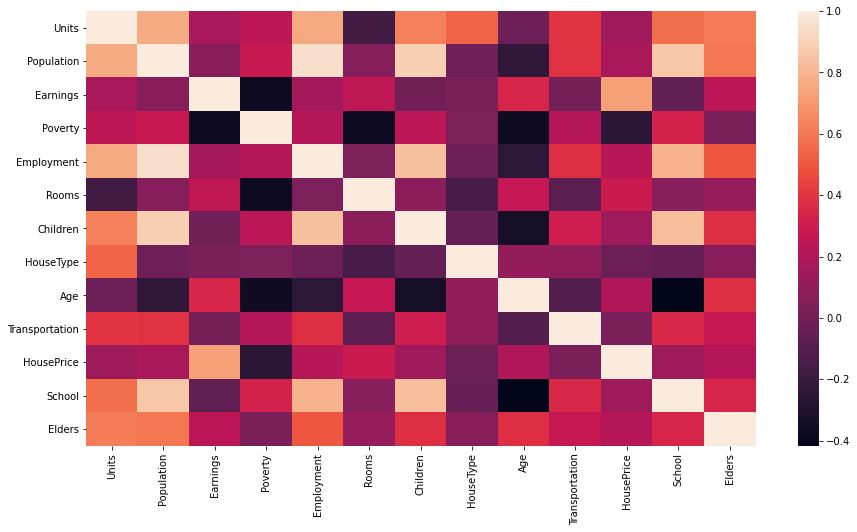

In [63]:
#Correlation plot involving all current features
plt.figure(figsize = (15,8))
sns.heatmap(HouseData_preFeatures.corr())

<Figure size 1080x576 with 0 Axes>

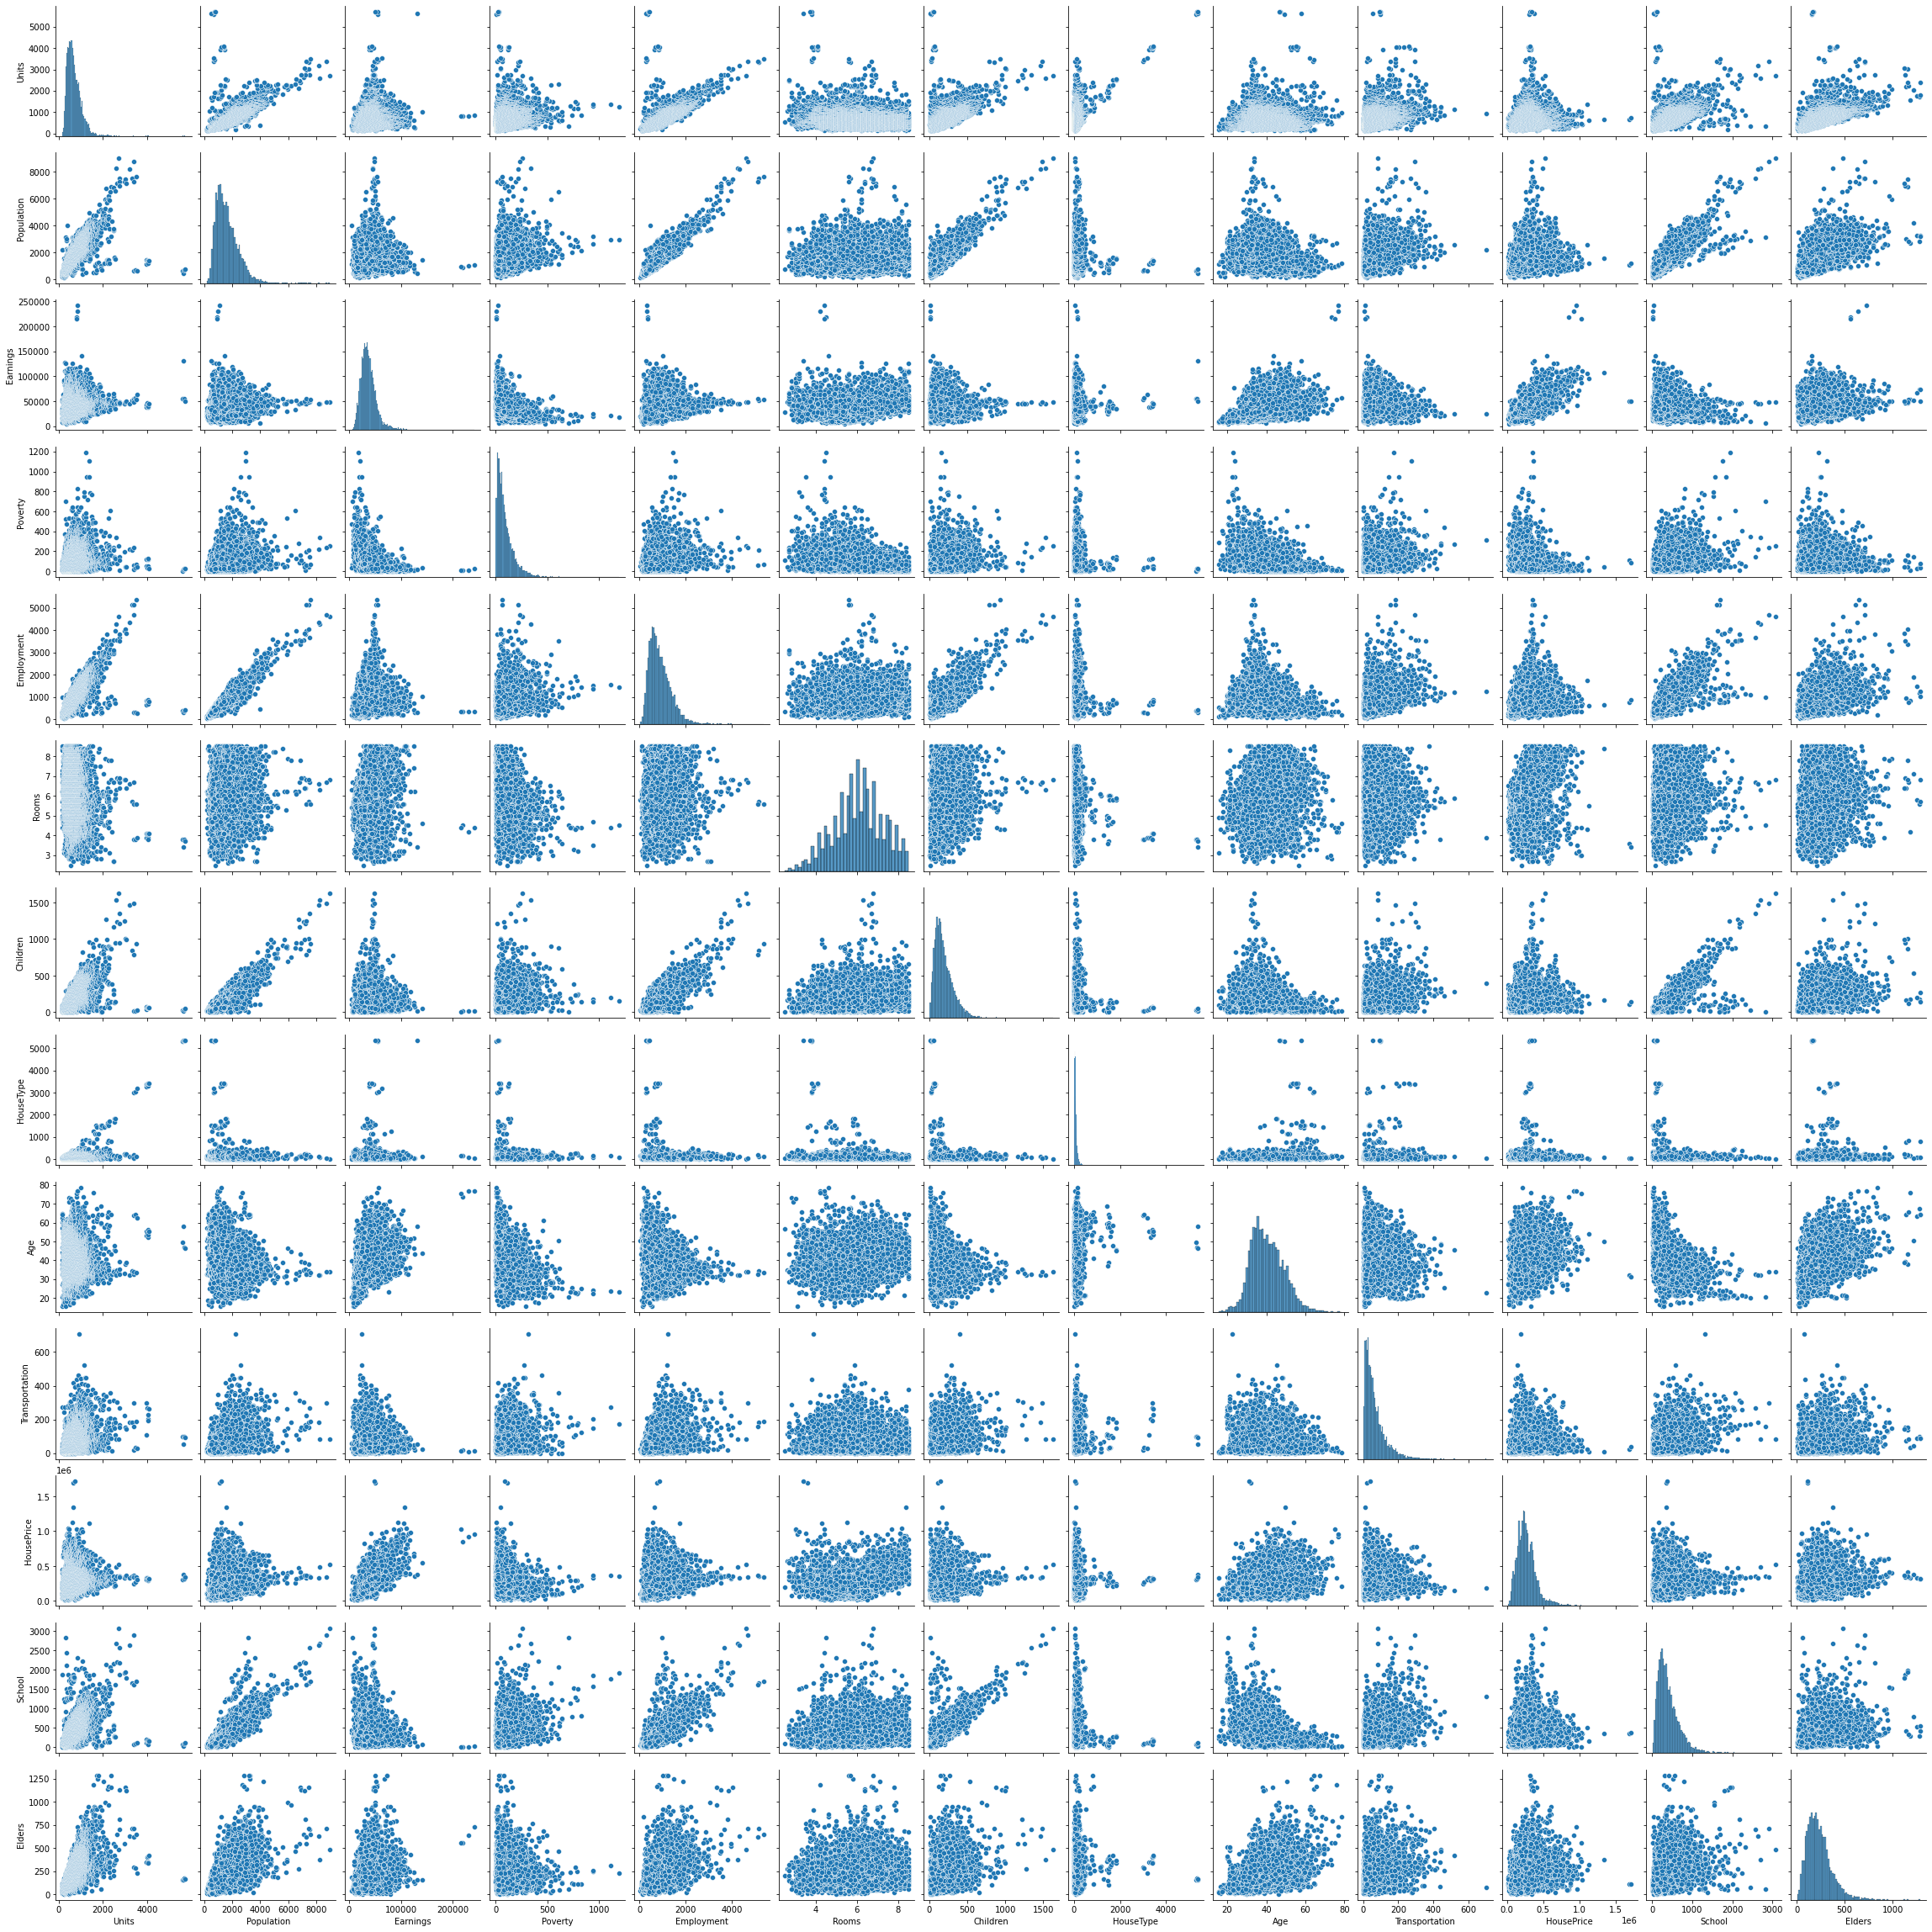

In [64]:
#Takes a minute to print all plots
plt.figure(figsize = (15,8))
sns.pairplot(HouseData_preFeatures)

<Figure size 1080x576 with 0 Axes>

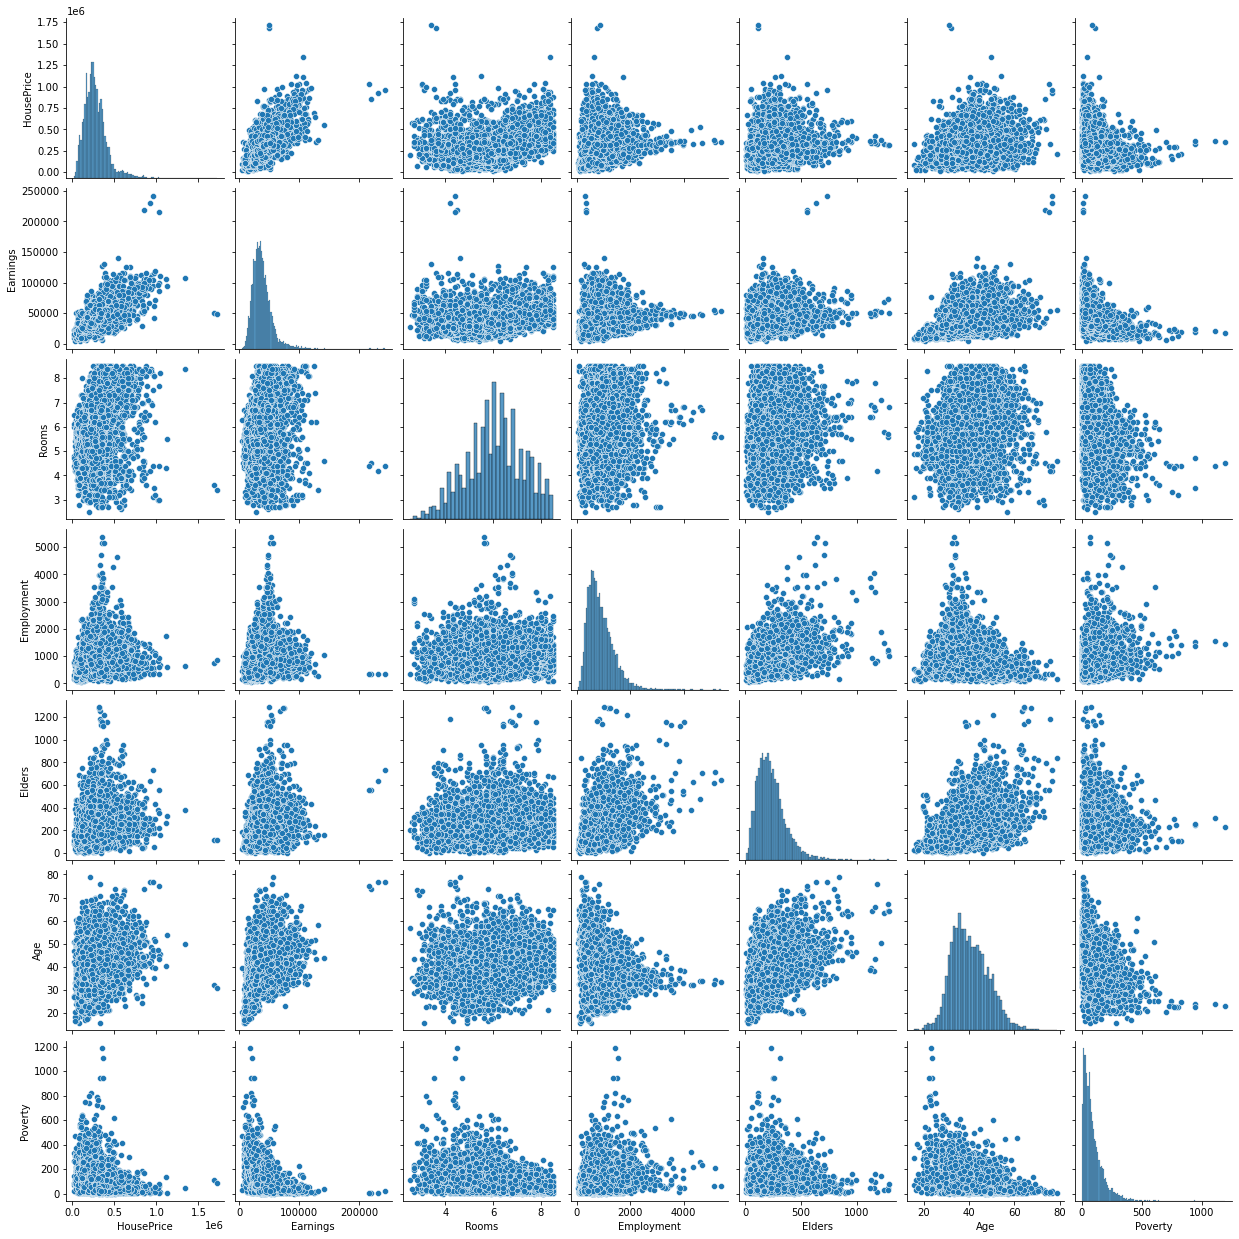

In [65]:
#Only looking at those with magnitude greater than .2 in correlation with target variable HousePrice

#HousePrice        1.000000
#Earnings          0.728548
#Rooms             0.288786
#Employment        0.223606
#Elders            0.208996
#Age               0.200824
#Poverty          -0.251223

list = ['HousePrice','Earnings','Rooms','Employment','Elders','Age','Poverty']
plt.figure(figsize = (15,8))
sns.pairplot(HouseData_preFeatures[list])

## New Attribute combinations

In [66]:
HouseData_preFeatures['house_per_person'] = HouseData_preFeatures['Units'] / HouseData_preFeatures['Population']
HouseData_preFeatures['working_per_person'] = HouseData_preFeatures['Employment'] / HouseData_preFeatures['Population']
HouseData_preFeatures['poverty_per_person'] = HouseData_preFeatures['Poverty'] / HouseData_preFeatures['Population']
HouseData_preFeatures['child_per_person'] = HouseData_preFeatures['Children'] / HouseData_preFeatures['Population']
HouseData_preFeatures['elder_per_person'] = HouseData_preFeatures['Elders'] / HouseData_preFeatures['Population']
HouseData_preFeatures['school_per_child'] = HouseData_preFeatures['School'] / HouseData_preFeatures['Children']
HouseData_preFeatures['close_commute'] = HouseData_preFeatures['Transportation'] / HouseData_preFeatures['Employment']
HouseData_preFeatures['vacancy_rate'] = HouseData_preFeatures['HouseType'] / HouseData_preFeatures['Units']
# Considered adding a yearly variable to account for a trend, but there may not be a constant increasing trend
# Earnings variable should help cover rises and falls in housing prices year to year due to inflation and larger macroeconomic trends


In [67]:
corr_matrix = HouseData_preFeatures.corr()
corr_matrix['HousePrice'].sort_values(ascending = False)

HousePrice            1.000000
Earnings              0.728548
Rooms                 0.288786
Employment            0.223606
Elders                0.208996
working_per_person    0.202459
Age                   0.200824
Population            0.185368
Units                 0.144814
Children              0.143622
School                0.138999
elder_per_person      0.073082
Transportation        0.022683
child_per_person     -0.005566
school_per_child     -0.005600
HouseType            -0.024967
house_per_person     -0.031835
close_commute        -0.138030
vacancy_rate         -0.220912
Poverty              -0.251223
poverty_per_person   -0.384094
Name: HousePrice, dtype: float64

In [68]:
corr_matrix.loc[((corr_matrix['HousePrice']>.2) | (corr_matrix['HousePrice']<-.2)),'HousePrice'].sort_values(ascending = False)

HousePrice            1.000000
Earnings              0.728548
Rooms                 0.288786
Employment            0.223606
Elders                0.208996
working_per_person    0.202459
Age                   0.200824
vacancy_rate         -0.220912
Poverty              -0.251223
poverty_per_person   -0.384094
Name: HousePrice, dtype: float64

<Figure size 1080x576 with 0 Axes>

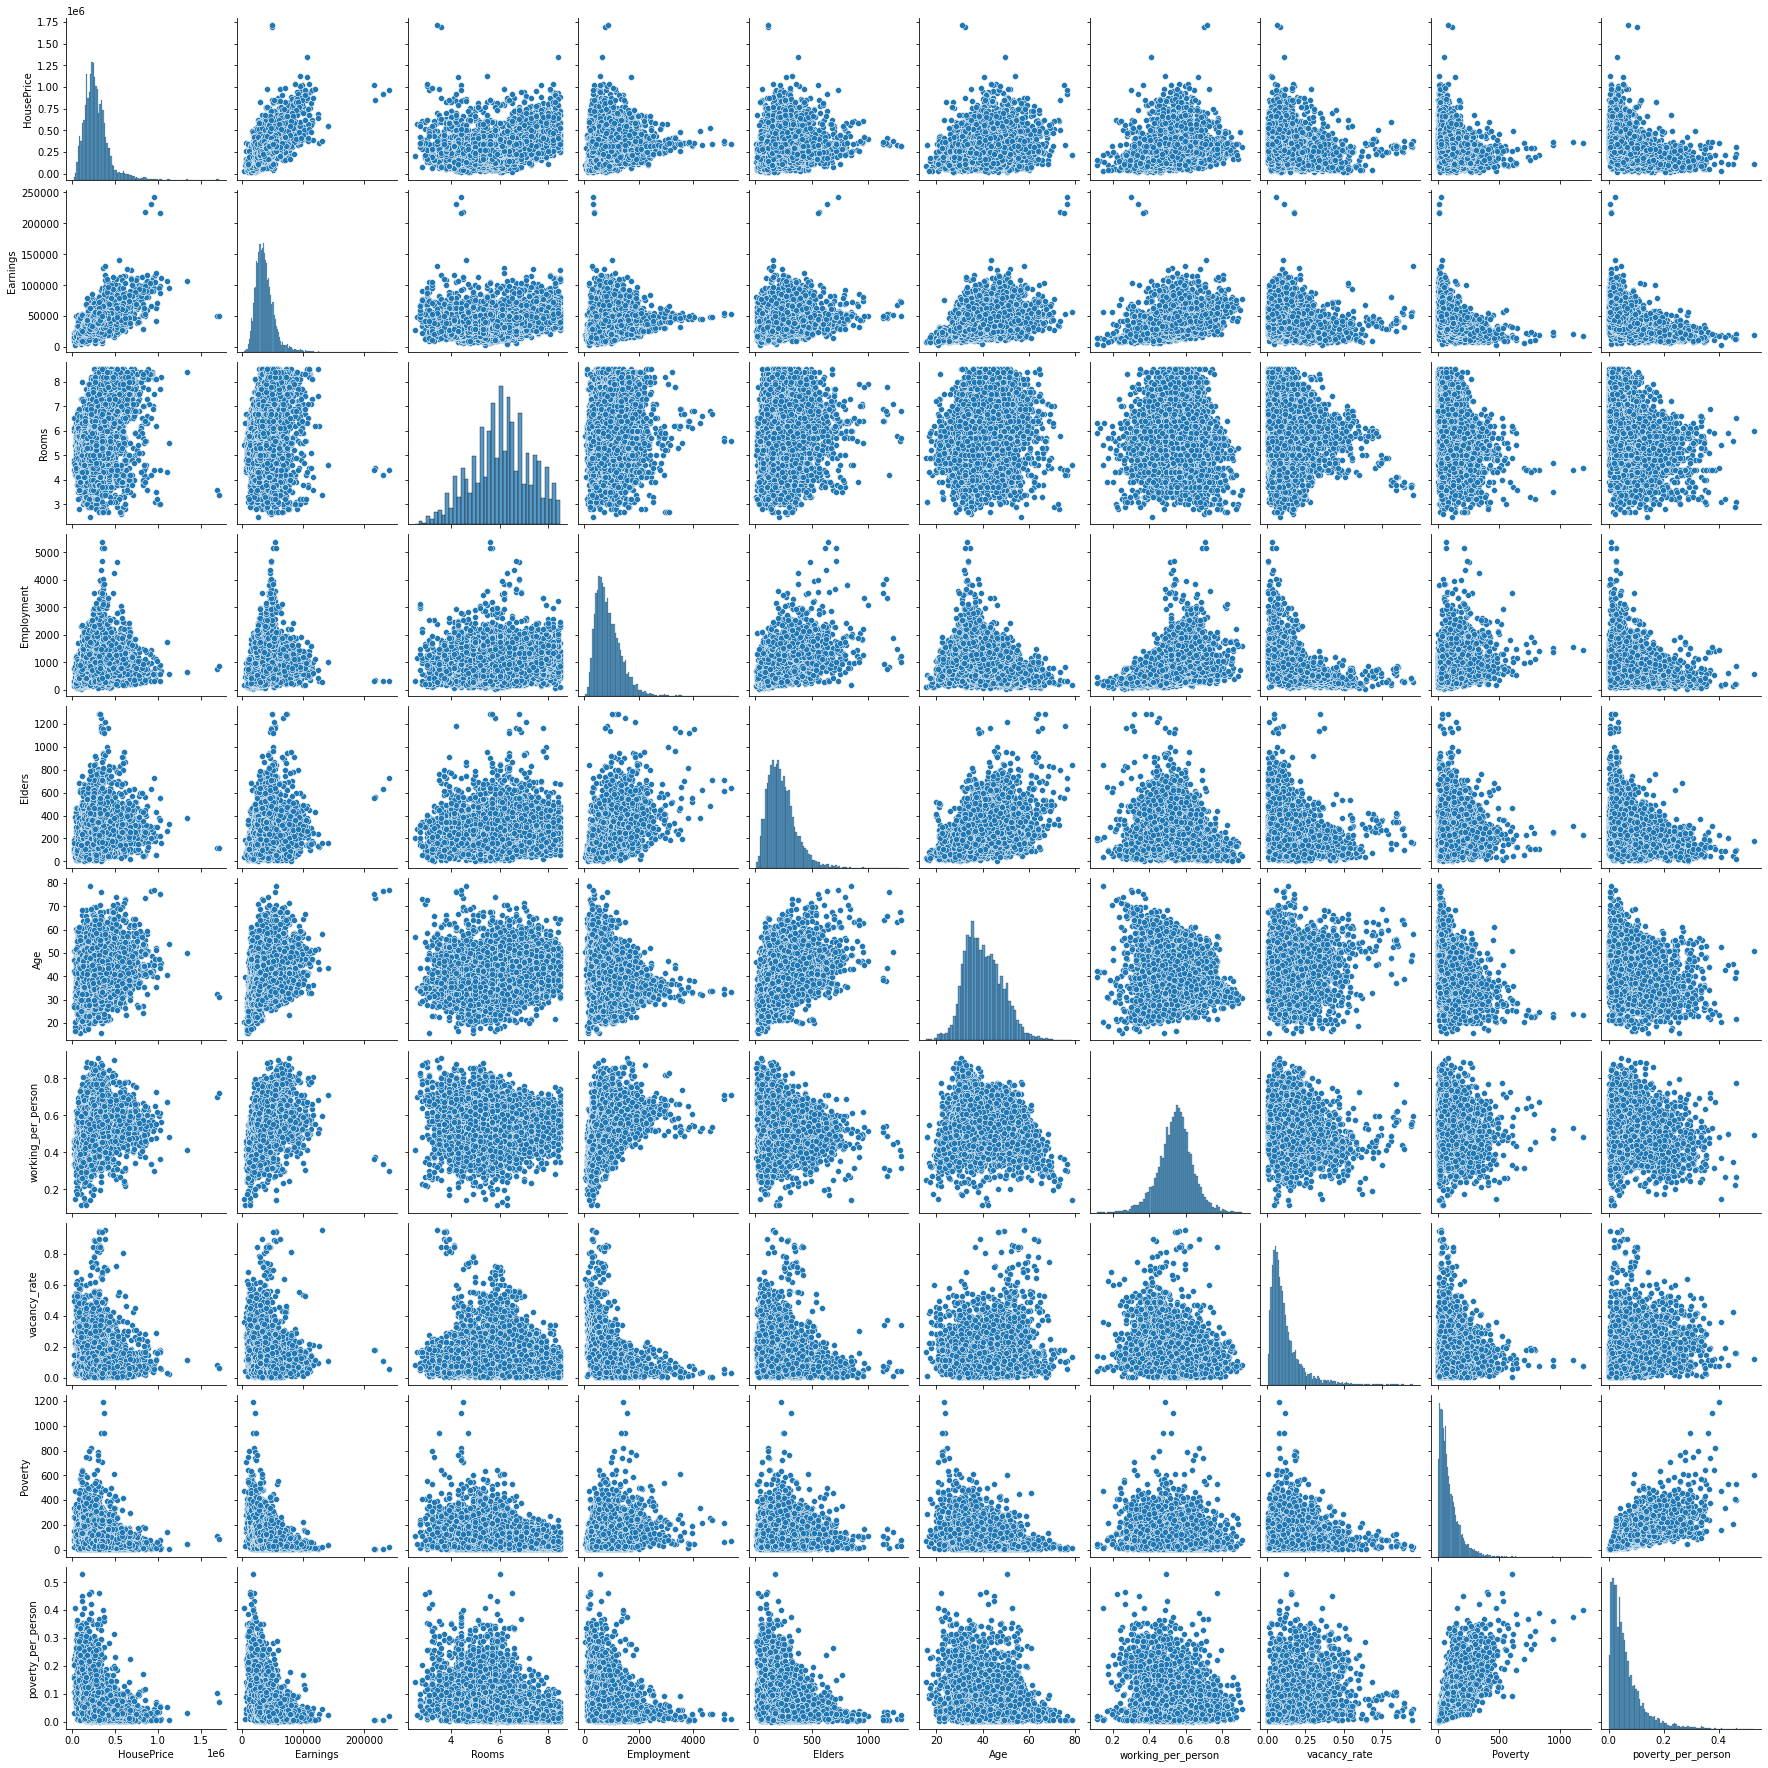

In [69]:
#Only looking at those with magnitude greater than .2 in correlation with target variable HousePrice
#HousePrice            1.000000
#Earnings              0.728548
#Rooms                 0.288786
#Employment            0.223606
#Elders                0.208996
#working_per_person    0.202459
#Age                   0.200824
#vacancy_rate         -0.220912
#Poverty              -0.251223
#poverty_per_person   -0.384094

list = ['HousePrice','Earnings','Rooms','Employment','Elders','Age','working_per_person','vacancy_rate','Poverty','poverty_per_person']
plt.figure(figsize = (15,8))
sns.pairplot(HouseData_preFeatures[list])

# Training Preparation

## Split response out and narrow potential feature list down

In [70]:
response = HouseData_preFeatures['HousePrice']

#Selecting those with correlation above .1 and not highly correlated with other features. Trying to avoid straight nominal variables like population
pre_training_features = HouseData_preFeatures[['Earnings','Rooms','Age','working_per_person','close_commute','vacancy_rate','poverty_per_person']]

## Standardize potential features

In [71]:
scaler_s = StandardScaler()

pre_training_features_standardized = scaler_s.fit_transform(pre_training_features)
names = pre_training_features.columns
pre_training_features_standardized = pd.DataFrame(pre_training_features_standardized, columns = names)
pre_training_features_standardized

Earnings     Rooms       Age  working_per_person  close_commute  \
0     0.873050  1.942297  2.662295           -1.949842       0.198638   
1    -1.395019 -1.066153  0.426843           -1.737789       4.702607   
2    -0.819455  0.103800 -0.931254           -0.763351       0.357030   
3    -0.533448 -1.400425  0.787399           -0.422797       2.308996   
4     0.813333  0.772344  2.025311            0.267784      -0.547049   
...        ...       ...       ...                 ...            ...   
8066  0.411752 -1.651129  1.796958            0.211954       3.622180   
8067  1.127175 -1.901833  1.063826            0.172267       2.656222   
8068  5.786859 -2.236105  2.109441            0.539678       1.432260   
8069  1.106813 -1.901833  0.787399           -0.014935       2.382243   
8070  0.803058 -1.985401  0.739325            0.097624       1.852462   

      vacancy_rate  poverty_per_person  
0         0.511527           -0.619207  
1         0.887260            4.267270  
2         3.135491            0.541742  
3         0.821180            0.114584  
4         0.700440            0.701891  
...            ...                 ...  
8066      6.931337           -0.716422  
8067      7.922187           -0.963891  
8068      7.966722           -0.301648  
8069      7.842542           -0.423887  
8070      7.823821           -0.530457  

[8071 rows x 7 columns]

## Normalize potential features

In [72]:
scaler_n = MinMaxScaler()

pre_training_features_normalized = scaler_n.fit_transform(pre_training_features)
names = pre_training_features.columns
pre_training_features_normalized = pd.DataFrame(pre_training_features_normalized, columns = names)
pre_training_features_normalized

Earnings     Rooms       Age  working_per_person  close_commute  \
0     0.200528  0.983333  0.744444            0.308694       0.150288   
1     0.047376  0.383333  0.449206            0.333975       0.648031   
2     0.086241  0.616667  0.269841            0.450149       0.167792   
3     0.105554  0.316667  0.496825            0.490751       0.383508   
4     0.196496  0.750000  0.660317            0.573083       0.067880   
...        ...       ...       ...                 ...            ...   
8066  0.169379  0.266667  0.630159            0.566427       0.528631   
8067  0.217688  0.216667  0.533333            0.561695       0.421881   
8068  0.532335  0.150000  0.671429            0.605498       0.286618   
8069  0.216313  0.216667  0.496825            0.539376       0.391603   
8070  0.195802  0.200000  0.490476            0.552796       0.333055   

      vacancy_rate  poverty_per_person  
0         0.175918            0.049777  
1         0.217450            0.604570  
2         0.465965            0.181587  
3         0.210146            0.133089  
4         0.196800            0.199770  
...            ...                 ...  
8066      0.885551            0.038740  
8067      0.995077            0.010643  
8068      1.000000            0.085831  
8069      0.986273            0.071953  
8070      0.984204            0.059853  

[8071 rows x 7 columns]

## Linear Regression to see significance of potential features

In [73]:
response = response.reset_index().drop(columns = {'index'})
OLS(response,pre_training_features_standardized).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             HousePrice   R-squared (uncentered):                   0.118
Model:                            OLS   Adj. R-squared (uncentered):              0.117
Method:                 Least Squares   F-statistic:                              154.2
Date:                Thu, 25 Aug 2022   Prob (F-statistic):                   1.79e-214
Time:                        19:38:46   Log-Likelihood:                     -1.1298e+05
No. Observations:                8071   AIC:                                  2.260e+05
Df Residuals:                    8064   BIC:                                  2.260e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Earnings            1.055e+05   4075.422     25.886      0.000    9.75e+04    1.13e+05
Rooms               1.266e+04   3669.554      3.449      0.001    5464.121    1.99e+04
Age                -1.364e+04   3750.607     -3.636      0.000    -2.1e+04   -6283.764
working_per_person -1.678e+04   3763.122     -4.460      0.000   -2.42e+04   -9405.342
close_commute      -2047.5828   3385.576     -0.605      0.545   -8684.186    4589.020
vacancy_rate       -1.208e+04   3552.118     -3.402      0.001    -1.9e+04   -5120.304
poverty_per_person -6874.1440   3944.477     -1.743      0.081   -1.46e+04     858.050
==============================================================================
Omnibus:                     3840.849   Durbin-Watson:                   0.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            93058.176
Skew:                           1.746   Prob(JB):                         0.00
Kurtosis:                      19.264   Cond. No.                         2.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
response = response.reset_index().drop(columns = {'index'})
OLS(response,pre_training_features_normalized).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             HousePrice   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                          1.107e+04
Date:                Thu, 25 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:38:46   Log-Likelihood:                     -1.0396e+05
No. Observations:                8071   AIC:                                  2.079e+05
Df Residuals:                    8064   BIC:                                  2.080e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Earnings            1.543e+06   1.97e+04     78.300      0.000     1.5e+06    1.58e+06
Rooms               1.194e+05   5182.075     23.037      0.000    1.09e+05     1.3e+05
Age                -3.676e+04   8544.234     -4.303      0.000   -5.35e+04      -2e+04
working_per_person  2265.8785   6741.628      0.336      0.737   -1.09e+04    1.55e+04
close_commute       1.307e+04   9865.245      1.325      0.185   -6267.688    3.24e+04
vacancy_rate       -8.067e+04   1.04e+04     -7.766      0.000   -1.01e+05   -6.03e+04
poverty_per_person  3.675e+04      1e+04      3.662      0.000    1.71e+04    5.64e+04
==============================================================================
Omnibus:                     3787.998   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82949.125
Skew:                           1.743   Prob(JB):                         0.00
Kurtosis:                      18.314   Cond. No.                         18.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Feature Selection and Create Training/Test Set

In [75]:
# Keep those recently scaled variables in as they appear to be significant and correlated enough to justify keeping them

In [76]:
#Split data in pre-scaled set into housing info and final features to be used. Will be rejoined for analysis purposes later
strat_train_set.is_copy = False #Only for this object disable warning

housing_info_train = strat_train_set[['GEO_ID','Name','Year']]
strat_train_set['working_per_person'] = strat_train_set['Employment'] / strat_train_set['Population']
strat_train_set['poverty_per_person'] = strat_train_set['Poverty'] / strat_train_set['Population']
strat_train_set['close_commute'] = strat_train_set['Transportation'] / strat_train_set['Employment']
strat_train_set['vacancy_rate'] = strat_train_set['HouseType'] / strat_train_set['Units']
X_train = strat_train_set[['Earnings','Rooms','Age','working_per_person','close_commute','vacancy_rate','poverty_per_person']]
y_train = strat_train_set['HousePrice']
#y_train = y_train.reset_index(drop=True)
y_train

<ipython-input-76-44fa4828919a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_train_set['working_per_person'] = strat_train_set['Employment'] / strat_train_set['Population']
<ipython-input-76-44fa4828919a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_train_set['poverty_per_person'] = strat_train_set['Poverty'] / strat_train_set['Population']
<ipython-input-76-44fa4828919a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

11601    433900.0
5877     189200.0
14582    446100.0
15249    352600.0
13528    447100.0
           ...   
9085     151900.0
5541     440000.0
8513     206800.0
5747     246100.0
12392    136300.0
Name: HousePrice, Length: 6460, dtype: float64

In [77]:
strat_test_set.is_copy = False #Only for this object disable warning

housing_info_test = strat_test_set[['GEO_ID','Name','Year']]
strat_test_set['working_per_person'] = strat_test_set['Employment'] / strat_test_set['Population']
strat_test_set['poverty_per_person'] = strat_test_set['Poverty'] / strat_test_set['Population']
strat_test_set['close_commute'] = strat_test_set['Transportation'] / strat_test_set['Employment']
strat_test_set['vacancy_rate'] = strat_test_set['HouseType'] / strat_test_set['Units']
X_test = strat_test_set[['Earnings','Rooms','Age','working_per_person','close_commute','vacancy_rate','poverty_per_person']]
y_test = strat_test_set['HousePrice']
#y_test = y_test.reset_index(drop=True)
y_test

<ipython-input-77-3ea87a64a0d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_test_set['working_per_person'] = strat_test_set['Employment'] / strat_test_set['Population']
<ipython-input-77-3ea87a64a0d4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_test_set['poverty_per_person'] = strat_test_set['Poverty'] / strat_test_set['Population']
<ipython-input-77-3ea87a64a0d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

11277    197300.0
3488     453000.0
12848    302700.0
8098     340800.0
7842     450000.0
           ...   
4718     221800.0
14948    236100.0
6678     119800.0
5009     262700.0
7618     268800.0
Name: HousePrice, Length: 1615, dtype: float64

# Scale the training and test set

## Standardize the features in training and test set

In [78]:
scaler_s = StandardScaler()

names = X_train.columns

# fit scaler on training data
stan = StandardScaler().fit(X_train)

# transform training data
X_train_Stan = stan.transform(X_train)
X_train_Stan = pd.DataFrame(X_train_Stan, columns = names)

# transform testing dataabs
X_test_Stan = stan.transform(X_test)
X_test_Stan = pd.DataFrame(X_test_Stan, columns = names)

X_test_Stan

Earnings     Rooms       Age  working_per_person  close_commute  \
0    -0.784077 -0.307999  1.097197           -1.131454      -0.584815   
1     0.917565  1.700081 -0.112533            0.503886      -0.629755   
2    -0.508874  0.110351 -1.274353           -0.190490      -0.222135   
3    -0.736375 -0.893689 -1.693566            1.037864      -1.072670   
4     3.185329 -2.483419 -0.998870            2.760899      -0.048342   
...        ...       ...       ...                 ...            ...   
1610  1.626671  0.696041  1.791893            0.922473       1.010052   
1611 -0.167964 -0.140659  0.558208           -0.462647      -0.006883   
1612 -1.041523 -0.307999  0.737871           -1.787505       3.910396   
1613 -0.419470  0.696041  0.486343           -1.538308      -0.245549   
1614  1.420887 -0.977359 -0.723387            2.530749       0.668807   

      vacancy_rate  poverty_per_person  
0        -0.008184            0.681311  
1        -0.555926           -1.053392  
2        -0.466116           -0.292019  
3        -0.656220           -0.353133  
4         0.150014           -0.129049  
...            ...                 ...  
1610      0.068784           -0.290162  
1611     -0.259485           -0.479932  
1612      2.287878            0.346962  
1613      1.178444            0.267159  
1614     -0.014985           -0.224058  

[1615 rows x 7 columns]

## Normalize the features in training and test set

In [79]:
scaler_n = MinMaxScaler()

names = X_train.columns

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_Norm = norm.transform(X_train)
X_train_Norm = pd.DataFrame(X_train_Norm, columns = names)

# transform testing dataabs
X_test_Norm = norm.transform(X_test)
X_test_Norm = pd.DataFrame(X_test_Norm, columns = names)
X_test_Norm

Earnings     Rooms       Age  working_per_person  close_commute  \
0     0.088415  0.533333  0.500000            0.404839       0.063516   
1     0.204060  0.933333  0.346970            0.601501       0.058454   
2     0.107118  0.616667  0.200000            0.517997       0.104370   
3     0.091657  0.416667  0.146970            0.665715       0.008562   
4     0.358180  0.100000  0.234848            0.872923       0.123946   
...        ...       ...       ...                 ...            ...   
1610  0.252252  0.733333  0.587879            0.651839       0.243169   
1611  0.130287  0.566667  0.431818            0.485268       0.128617   
1612  0.070919  0.533333  0.454545            0.325944       0.569876   
1613  0.113194  0.733333  0.422727            0.355912       0.101732   
1614  0.238266  0.400000  0.269697            0.845246       0.204729   

      vacancy_rate  poverty_per_person  
0         0.119470            0.197665  
1         0.058132            0.000617  
2         0.068189            0.087103  
3         0.046901            0.080161  
4         0.137186            0.105615  
...            ...                 ...  
1610      0.128089            0.087313  
1611      0.091329            0.065757  
1612      0.376592            0.159685  
1613      0.252353            0.150620  
1614      0.118709            0.094822  

[1615 rows x 7 columns]

# Create a benchmark model

In [80]:
# Use a benchmark model with earnings only to compare to

#Create Linear Regression class
lr = LinearRegression()

rmse = []

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_Norm, X_train_Stan]
testX = [X_test, X_test_Norm, X_test_Stan]

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    lr.fit(trainX[i],y_train)
    # predict
    pred = lr.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    
# visualizing the result
df_benchmark = pd.DataFrame({'Benchmark RMSE':rmse},index=['Original','Normalized','Standardized'])
df_benchmark

Benchmark RMSE
Original        89644.037632
Normalized      89644.037632
Standardized    89644.037632

# Train and Test Models

## Gradient Boosting

### Default Model

In [81]:
# Use a benchmark model with earnings only to compare to

#Create Linear Regression class
gbrt = GradientBoostingRegressor()

rmse = []

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    gbrt.fit(trainX[i],y_train)
    # predict
    pred = gbrt.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    
# visualizing the result
df_gbrt = pd.DataFrame({'Gradient Boosting RMSE':rmse},index=['Original','Normalized','Standardized'])
df_gbrt

Gradient Boosting RMSE
Original                83032.335552
Normalized              82967.118031
Standardized            82946.892679

### GridSearch

#### Grid Search Cell Testing
df_transformation=['Gradient Boosting Original','Gradient Boosting Normalized','Gradient Boosting Standardized']
df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'max_depth': [4,8,16,32], 'n_estimators': [200,400,600],'learning_rate': [.01,.1,.2,.3,.4]}
    classifier = GradientBoostingRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')
    

#### Grid Search Cell Testing
df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'max_depth': [2,4,6], 'n_estimators': [600,800],'learning_rate': [.01,.05]}
    classifier = GradientBoostingRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### GridSearch Used

In [82]:
# -----
# Final GradientBoostingRegressor GridSearch
#   Repeated search to make sure that optimal hyperparameter values found are indeed optimal
# -----
df_index = 0
rmse = []
df_transformation=['Gradient Boosting Original','Gradient Boosting Normalized','Gradient Boosting Standardized']

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'max_depth': [4], 'n_estimators': [1000],'learning_rate': [.01]}
    classifier = GradientBoostingRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')
    
    # predict
    pred = grid_search_cv.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

# visualizing the result
df_gbrt_grid = pd.DataFrame({'Gradient Boosting Grid Search RMSE':rmse},index=['Original','Normalized','Standardized'])
df_gbrt_grid

Fitting 3 folds for each of 1 candidates, totalling 3 fits
The best parameters for  Gradient Boosting Original :  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
The time for the above operation:  31.23887586593628 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
The best parameters for  Gradient Boosting Normalized :  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
The time for the above operation:  31.152127742767334 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
The best parameters for  Gradient Boosting Standardized :  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
The time for the above operation:  34.04522681236267 



Gradient Boosting Grid Search RMSE
Original                            81950.338598
Normalized                          81941.004194
Standardized                        81940.163509

On this dataset, the optimal model parameters for the `Gradient Boosting` class are:

- `max_depth = 4`
- `learning_rate = .01`
- `n_estimators = 1000`

On this dataset, the optimal model parameters for the `Gradient Boosting` Normalized class are:

- `max_depth = 4`
- `learning_rate = .01`
- `n_estimators = 1000`

On this dataset, the optimal model parameters for the `Gradient Boosting` Standardized class are:

- `max_depth = 4`
- `learning_rate = .01`
- `n_estimators = 1000`

## Random Forest

### Default Model

In [83]:
# Use a benchmark model with earnings only to compare to

#Create Linear Regression class
rf = RandomForestRegressor()

rmse = []

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    rf.fit(trainX[i],y_train)
    # predict
    pred = rf.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    
# visualizing the result
df_rf = pd.DataFrame({'Random Forest RMSE':rmse},index=['Original','Normalized','Standardized'])
df_rf

Random Forest RMSE
Original            82910.703832
Normalized          82274.105716
Standardized        81645.789074

### GridSearch

#### Grid Search Cell Testing
df_transformation=['Random Forest Original','Random Forest Normalized','Random Forest Standardized']
df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'max_depth': [4,8,16,32], 'n_estimators': [200,400,600],'min_samples_split': [10,12,14]}
    classifier = RandomForestRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### Grid Search Cell Testing

df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'max_depth': [12,16,20], 'n_estimators': [600,700,800],'min_samples_split': [8,10,12]}
    classifier = RandomForestRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### GridSearch Used

In [84]:
# -----
# Final RandomForestRegressor GridSearch
#   Repeated search to make sure that optimal hyperparameter values found are indeed optimal
# -----
df_index = 0
rmse = []
df_transformation=['Random Forest Original','Random Forest Normalized','Random Forest Standardized']

for i in range(len(trainX)):
    start = time.time()
    param_grid={'max_depth': [14,16], 'n_estimators': [800],'min_samples_split': [11,12]}
    classifier = RandomForestRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')
    
    # predict
    pred = grid_search_cv.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

# visualizing the result
df_rf_grid = pd.DataFrame({'Random Forest Grid Search RMSE':rmse},index=['Original','Normalized','Standardized'])
df_rf_grid

Fitting 3 folds for each of 4 candidates, totalling 12 fits
The best parameters for  Random Forest Original :  {'max_depth': 16, 'min_samples_split': 12, 'n_estimators': 800}
The time for the above operation:  129.9264976978302 

Fitting 3 folds for each of 4 candidates, totalling 12 fits
The best parameters for  Random Forest Normalized :  {'max_depth': 14, 'min_samples_split': 11, 'n_estimators': 800}
The time for the above operation:  128.04062676429749 

Fitting 3 folds for each of 4 candidates, totalling 12 fits
The best parameters for  Random Forest Standardized :  {'max_depth': 14, 'min_samples_split': 11, 'n_estimators': 800}
The time for the above operation:  134.61315321922302 



Random Forest Grid Search RMSE
Original                        82098.776204
Normalized                      82075.214006
Standardized                    82074.417004

On this dataset, the optimal model parameters for the `Random Forest` class are:

- `max_depth = 16`
- `n_estimators = 800`
- `min_samples_split = 12`

On this dataset, the optimal model parameters for the `Random Forest` Normalized class are:

- `max_depth = 14`
- `n_estimators = 800`
- `min_samples_split = 11`

On this dataset, the optimal model parameters for the `Random Forest` Standardized class are:

- `max_depth = 14`
- `n_estimators = 800`
- `min_samples_split = 11`

## Decision Tree

### Default Model

In [85]:
# Use a benchmark model with earnings only to compare to

#Create Decision Tree class
tree = DecisionTreeRegressor()

rmse = []

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    tree.fit(trainX[i],y_train)
    # predict
    pred = tree.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    
# visualizing the result
df_tree = pd.DataFrame({'Decision Tree RMSE':rmse},index=['Original','Normalized','Standardized'])
df_tree

Decision Tree RMSE
Original           111469.832290
Normalized         115036.152562
Standardized       114073.239007

### Grid Search

#### Grid Search Cell Testing
df_transformation=['Decision Tree Original','Decision Tree Normalized','Decision Tree Standardized']
df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'max_depth': [4,8,16,32], 'splitter' : ["best", "random"],'min_samples_split': [10,12,14]}
    classifier = DecisionTreeRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### Grid Search Cell Testing

df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'max_depth': [2,4,6], 'splitter' : ["best", "random"],'min_samples_split': [8,10,12]}
    classifier = DecisionTreeRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### GridSearch Used

In [86]:
# -----
# Final GradientBoostingRegressor GridSearch
#   Repeated search to make sure that optimal hyperparameter values found are indeed optimal
# -----

df_index = 0
rmse = []
df_transformation=['Decision Tree Original','Decision Tree Normalized','Decision Tree Standardized']

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'max_depth': [4], 'splitter' : ["best"],'min_samples_split': [2]}
    classifier = DecisionTreeRegressor(random_state=42)
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')
    # predict
    pred = grid_search_cv.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

# visualizing the result
df_tree_grid = pd.DataFrame({'Decision Tree Grid Search RMSE':rmse},index=['Original','Normalized','Standardized'])
df_tree_grid

Fitting 3 folds for each of 1 candidates, totalling 3 fits
The best parameters for  Decision Tree Original :  {'max_depth': 4, 'min_samples_split': 2, 'splitter': 'best'}
The time for the above operation:  0.06183481216430664 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
The best parameters for  Decision Tree Normalized :  {'max_depth': 4, 'min_samples_split': 2, 'splitter': 'best'}
The time for the above operation:  0.05088615417480469 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
The best parameters for  Decision Tree Standardized :  {'max_depth': 4, 'min_samples_split': 2, 'splitter': 'best'}
The time for the above operation:  0.032979726791381836 



Decision Tree Grid Search RMSE
Original                        91826.782804
Normalized                      91826.782804
Standardized                    91826.782804

On this dataset, the optimal model parameters for the `Decision Tree` class are:

- `max_depth = 4`
- `splitter = best`
- `min_samples_split = 2`

On this dataset, the optimal model parameters for the `Decision Tree` Normalized class are:

- `max_depth = 4`
- `splitter = best`
- `min_samples_split = 2`

On this dataset, the optimal model parameters for the `Decision Tree` Standardized class are:

- `max_depth = 4`
- `splitter = best`
- `min_samples_split = 2`

## K Neighbors

### Default Model

In [87]:
# knn 
knn = KNeighborsRegressor(n_neighbors=7)

rmse = []

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    knn.fit(trainX[i],y_train)
    # predict
    pred = knn.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

# visualizing the result
df_knn = pd.DataFrame({'KNN RMSE':rmse},index=['Original','Normalized','Standardized'])
df_knn

KNN RMSE
Original      98873.439753
Normalized    87712.042556
Standardized  84974.962549

### GridSearch

#### Grid Search Cell Testing

df_transformation=['K Neighbors Original','K Neighbors Normalized','K Neighbors Standardized']
df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'n_neighbors': [11,21,31,41,51], 'weights' : ["uniform", "distance"],'metric': ["euclidean", "manhattan"]}
    classifier = KNeighborsRegressor()
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### Grid Search Cell Testing
df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'n_neighbors': [51,61,71,81,91], 'weights' : ["uniform", "distance"],'metric': ["euclidean", "manhattan"]}
    classifier = KNeighborsRegressor()
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### GridSearch Used

In [88]:
# -----
# Final KNeighborsRegressor GridSearch
#   Repeated search to make sure that optimal hyperparameter values found are indeed optimal
# -----

df_index = 0
rmse = []
df_transformation=['K Neighbors Original','K Neighbors Normalized','K Neighbors Standardized']

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'n_neighbors': [5,9,81], 'weights' : ["uniform", "distance"],'metric': ["euclidean", "manhattan"]}
    classifier = KNeighborsRegressor()
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')
    # predict
    pred = grid_search_cv.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

# visualizing the result
df_knn_grid = pd.DataFrame({'K Neighbor Grid Search RMSE':rmse},index=['Original','Normalized','Standardized'])
df_knn_grid

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters for  K Neighbors Original :  {'metric': 'manhattan', 'n_neighbors': 81, 'weights': 'uniform'}
The time for the above operation:  0.6318738460540771 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters for  K Neighbors Normalized :  {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
The time for the above operation:  2.623410224914551 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters for  K Neighbors Standardized :  {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
The time for the above operation:  2.8596763610839844 



K Neighbor Grid Search RMSE
Original                     94298.285170
Normalized                   85690.983603
Standardized                 83654.420658

On this dataset, the optimal model parameters for the `KNeighbors` class are:

- `metric = manhattan`
- `n_neighbors = 81`
- `weights = uniform`

On this dataset, the optimal model parameters for the `KNeighbors` Normalized class are:

- `metric = euclidean`
- `n_neighbors = 9`
- `weights = distance`

On this dataset, the optimal model parameters for the `KNeighbors` Standardized class are:

- `metric = manhattan`
- `n_neighbors = 5`
- `weights = distance`

## Support Vector 

### Default Model

In [89]:
# SVR
svr = SVR(kernel='rbf',C=5)

rmse = []

# model fitting and measuring RMSE
for i in range(len(trainX)):
    
    # fit
    svr.fit(trainX[i],y_train)
    # predict
    pred = svr.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

# visualizing the result    
df_svr = pd.DataFrame({'Support Vector RMSE':rmse},index=['Original','Normalized','Standardized'])
df_svr


Support Vector RMSE
Original            138699.621766
Normalized          139600.106967
Standardized        139520.737472

### GridSearch

#### Grid Search Cell Testing
df_transformation=['SVM Original','SVM Normalized','SVM Standardized']
df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'C': [0.1,1], 'gamma': [0.01,0.001],'kernel': ['rbf']}
    classifier = SVR()
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### Grid Search Cell Testing

df_index = 0

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'C': [1, 5], 'gamma': [0.0001,0.001],'kernel': ['rbf']}
    classifier = SVR()
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')

#### GridSearch Used

In [96]:
df_index = 0
rmse = []

for i in range(len(trainX)):
    start = time.time()
    
    param_grid={'C': [50], 'gamma': [0.001,.0005],'kernel': ['rbf']}
    classifier = SVR()
    grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

    grid_search_cv.fit(trainX[i], y_train)
    print("The best parameters for ",df_transformation[df_index],': ', grid_search_cv.best_params_)
    df_index +=1
    print("The time for the above operation: ",time.time() - start,'\n')
    # predict
    pred = grid_search_cv.predict(testX[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    
# visualizing the result
df_svm_grid = pd.DataFrame({'SVM Grid Search RMSE':rmse},index=['Original','Normalized','Standardized'])
df_svm_grid

Fitting 3 folds for each of 2 candidates, totalling 6 fits
The best parameters for  SVM Original :  {'C': 50, 'gamma': 0.0005, 'kernel': 'rbf'}
The time for the above operation:  17.824466705322266 

Fitting 3 folds for each of 2 candidates, totalling 6 fits
The best parameters for  SVM Normalized :  {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}
The time for the above operation:  10.934126377105713 

Fitting 3 folds for each of 2 candidates, totalling 6 fits
The best parameters for  SVM Standardized :  {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}
The time for the above operation:  11.09691858291626 



SVM Grid Search RMSE
Original             140284.517164
Normalized           140376.954508
Standardized         139924.242331

On this dataset, the optimal model parameters for the `SVM` class are:

- `C = 50`
- `gamma = .005`
- `kernel = rbf`

On this dataset, the optimal model parameters for the `SVM` Normalized class are:

- `C = 50`
- `gamma = .001`
- `kernel = rbf`

On this dataset, the optimal model parameters for the `SVM` Standardized class are:

- `C = 50`
- `gamma = .001`
- `kernel = rbf`

# Artificial Neural Networks

## Create training and validation sets

In [101]:
X_train_ANN, X_valid_ANN, y_train_ANN, y_valid_ANN = train_test_split(X_train,y_train,test_size=0.25,random_state=42)


#Split training data into smaller training set and validation set
X_train_ANN_Norm, X_valid_ANN_Norm, y_train_ANN, y_valid_ANN = train_test_split(X_train_Norm,y_train,test_size=0.25,random_state=42)

#Split training data into smaller training set and validation set
X_train_ANN_Stan, X_valid_ANN_Stan, y_train_ANN, y_valid_ANN = train_test_split(X_train_Stan,y_train,test_size=0.25,random_state=42)

# raw, normalized and standardized training data
trainX_ANN = [X_train_ANN, X_train_ANN_Norm, X_train_ANN_Stan]

validX = [X_valid_ANN,X_valid_ANN_Norm,X_valid_ANN_Stan]

## Run ANNs

In [113]:
#Run Sequential Class model with 4 layers
df_index = 0
rmse = []
df_transformation=['ANN Original','ANN Normalized','ANN Standardized']

for i in range(len(trainX)):

    tf.random.set_seed(42)

    model_ANN = keras.models.Sequential()
    model_ANN.add(keras.layers.Flatten(input_shape=[7]))
    model_ANN.add(keras.layers.Dense(1000,activation="softmax"))
    model_ANN.add(keras.layers.Dense(100,activation="softmax"))
    model_ANN.add(keras.layers.Dense(10,activation="softmax"))
    model_ANN.add(keras.layers.Dense(1))


    model_ANN.compile(loss=tf.keras.metrics.mean_squared_error,
              optimizer=keras.optimizers.SGD(learning_rate=0.01),metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    history = model_ANN.fit(trainX_ANN[i],y_train_ANN,epochs=25,validation_data=(validX[i],y_valid_ANN))

    rmse.append(model_ANN.evaluate(testX[i],y_test))

# visualizing the result
df_ann = pd.DataFrame({'ANN Grid Search RMSE':rmse[0][1]},index=['Original','Normalized','Standardized'])
df_ann

Epoch 1/25
152/152 [==============================] - 1s 3ms/step - loss: 26632675328.0000 - rmse: 163195.2031 - val_loss: 20480333824.0000 - val_rmse: 143109.5156
Epoch 2/25
152/152 [==============================] - 0s 2ms/step - loss: 19993257984.0000 - rmse: 141397.5156 - val_loss: 20473917440.0000 - val_rmse: 143087.0938
Epoch 3/25
152/152 [==============================] - 0s 3ms/step - loss: 19986905088.0000 - rmse: 141375.0469 - val_loss: 20574451712.0000 - val_rmse: 143437.9688
Epoch 4/25
152/152 [==============================] - 0s 3ms/step - loss: 19989417984.0000 - rmse: 141383.9375 - val_loss: 20473714688.0000 - val_rmse: 143086.3906
Epoch 5/25
152/152 [==============================] - 0s 2ms/step - loss: 20003203072.0000 - rmse: 141432.6875 - val_loss: 20475697152.0000 - val_rmse: 143093.3125
Epoch 6/25
152/152 [==============================] - 0s 2ms/step - loss: 19996471296.0000 - rmse: 141408.8750 - val_loss: 20485505024.0000 - val_rmse: 143127.5781
Epoch 7/25
152/1

ANN Grid Search RMSE
Original             138698.046875
Normalized           138698.046875
Standardized         138698.046875

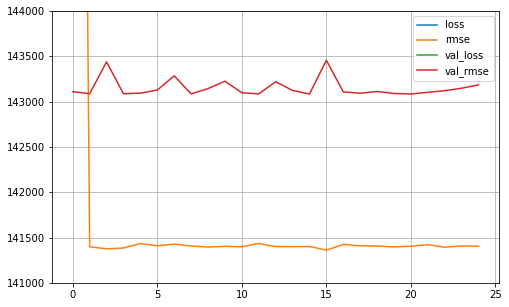

In [117]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(141000, 144000)
plt.grid(True)
plt.show()

# Compare Generalization across models

## Default Models

In [116]:
pd.concat([df_benchmark,df_gbrt,df_tree,df_rf,df_knn,df_svr,df_ann],axis=1)

Benchmark RMSE  Gradient Boosting RMSE  Decision Tree RMSE  \
Original        89644.037632            83032.335552       111469.832290   
Normalized      89644.037632            82967.118031       115036.152562   
Standardized    89644.037632            82946.892679       114073.239007   

              Random Forest RMSE      KNN RMSE  Support Vector RMSE  \
Original            82910.703832  98873.439753        138699.621766   
Normalized          82274.105716  87712.042556        139600.106967   
Standardized        81645.789074  84974.962549        139520.737472   

              ANN Grid Search RMSE  
Original             138698.046875  
Normalized           138698.046875  
Standardized         138698.046875

## GridSearch

In [114]:
pd.concat([df_gbrt_grid,df_rf_grid,df_tree_grid,df_knn_grid,df_svm_grid],axis = 1)

Gradient Boosting Grid Search RMSE  \
Original                            81950.338598   
Normalized                          81941.004194   
Standardized                        81940.163509   

              Random Forest Grid Search RMSE  Decision Tree Grid Search RMSE  \
Original                        82098.776204                    91826.782804   
Normalized                      82075.214006                    91826.782804   
Standardized                    82074.417004                    91826.782804   

              K Neighbor Grid Search RMSE  SVM Grid Search RMSE  
Original                     94298.285170         140284.517164  
Normalized                   85690.983603         140376.954508  
Standardized                 83654.420658         139924.242331

# Chosen Model

Gradient Boosting Grid Search

# Flask Application